<a href="https://colab.research.google.com/github/xmuruaga/hazardous-asteroids/blob/main/Planetary_Defense_Hazardous_Asteroids_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Environment setup

In [ ]:
import os

In [ ]:
from google.colab import userdata
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!kaggle datasets download -d sameepvani/nasa-nearest-earth-objects --force

!unzip -o -q nasa-nearest-earth-objects.zip


Dataset URL: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects
License(s): CC0-1.0
  0% 0.00/6.60M [00:00<?, ?B/s]
100% 6.60M/6.60M [00:00<00:00, 145MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import joblib
import time

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
data = pd.read_csv('neo.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [ ]:
data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [ ]:
data.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


# 1 Data Analysis

## 1.1 Correlation Analysis

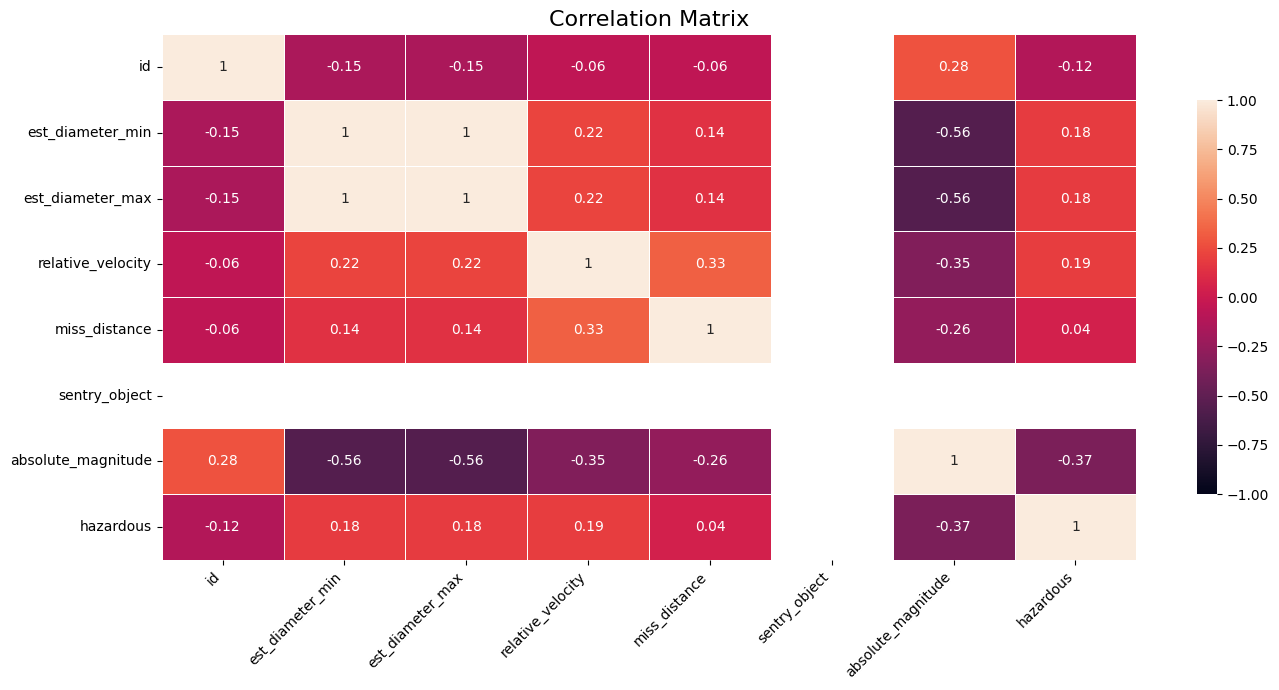

In [ ]:
# Calcular la matriz de correlación
correlation = data.corr(method='pearson', min_periods=1, numeric_only=True).round(2)

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 7))

# Crear el heatmap
sns.heatmap(correlation, annot=True, cmap='rocket', vmin=-1, vmax=1, center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

# Título y ajuste del layout
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar el heatmap
plt.show()

## 1.2 Pairplot

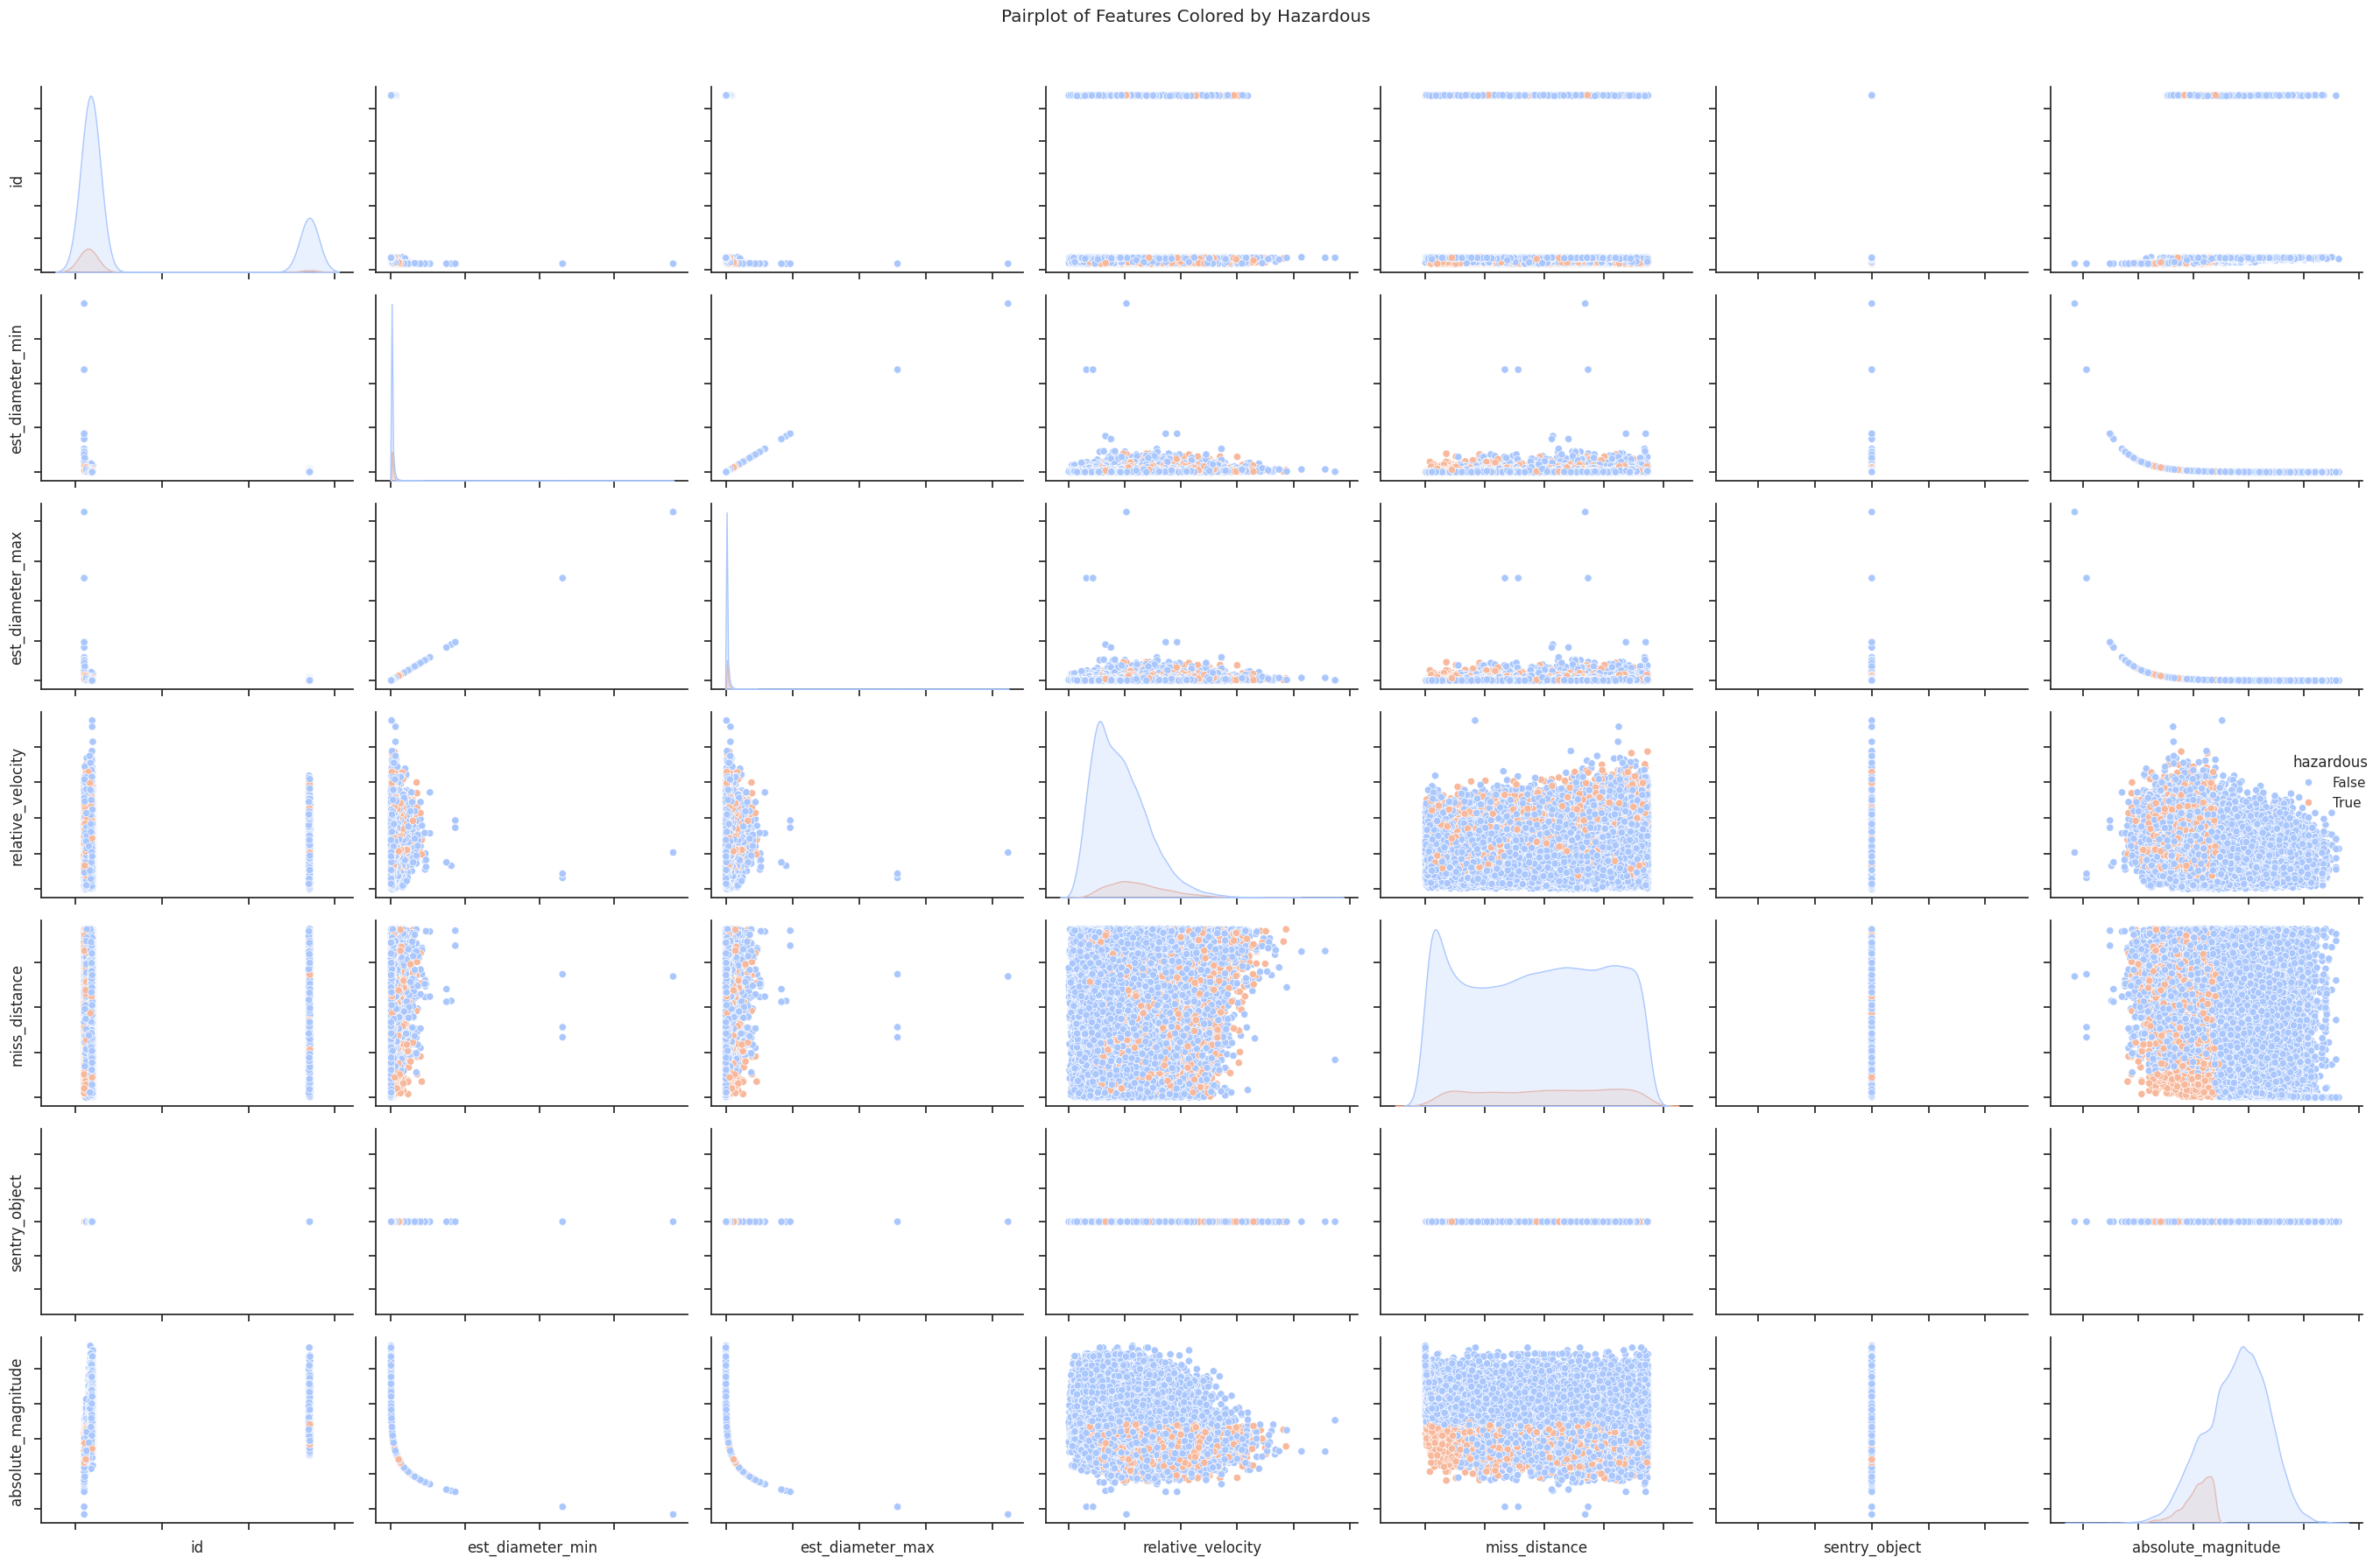

In [ ]:
# Configuración del estilo de seaborn
sns.set(style="ticks", color_codes=True)

# Crear el pairplot
pairplot = sns.pairplot(
    data,
    aspect=1.5,  # Ajusta el aspecto de los gráficos
    kind='scatter',  # Tipo de gráfico (puede ser 'scatter' o 'reg' para incluir regresión)
    hue='hazardous',  # Variable para colorear los puntos
    palette='coolwarm'  # Paleta de colores
)

# Ajustar las etiquetas de los ejes y el título
pairplot.fig.suptitle('Pairplot of Features Colored by Hazardous', y=1.02)
pairplot.set(xticklabels=[], yticklabels=[])

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

## 1.3 Bar Graph

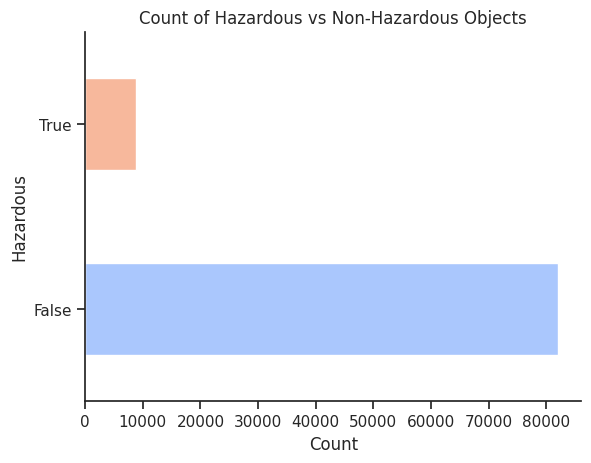

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Obtener la paleta 'coolwarm' de seaborn
palette = sns.color_palette("coolwarm", 2)  # Obtener 2 colores de la paleta 'coolwarm'

# Asignar los colores a las categorías
color_dict = {'False': palette[0], 'True': palette[1]}  # Usar el primer color para False y el segundo para True

# Crear el gráfico de barras horizontales
bar_colors = [color_dict[str(val)] for val in data['hazardous'].unique()]
data.groupby('hazardous').size().plot(kind='barh', color=bar_colors)

# Ajustar el estilo del gráfico
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Count of Hazardous vs Non-Hazardous Objects')
plt.xlabel('Count')
plt.ylabel('Hazardous')
plt.show()


## 1.4 Histogram

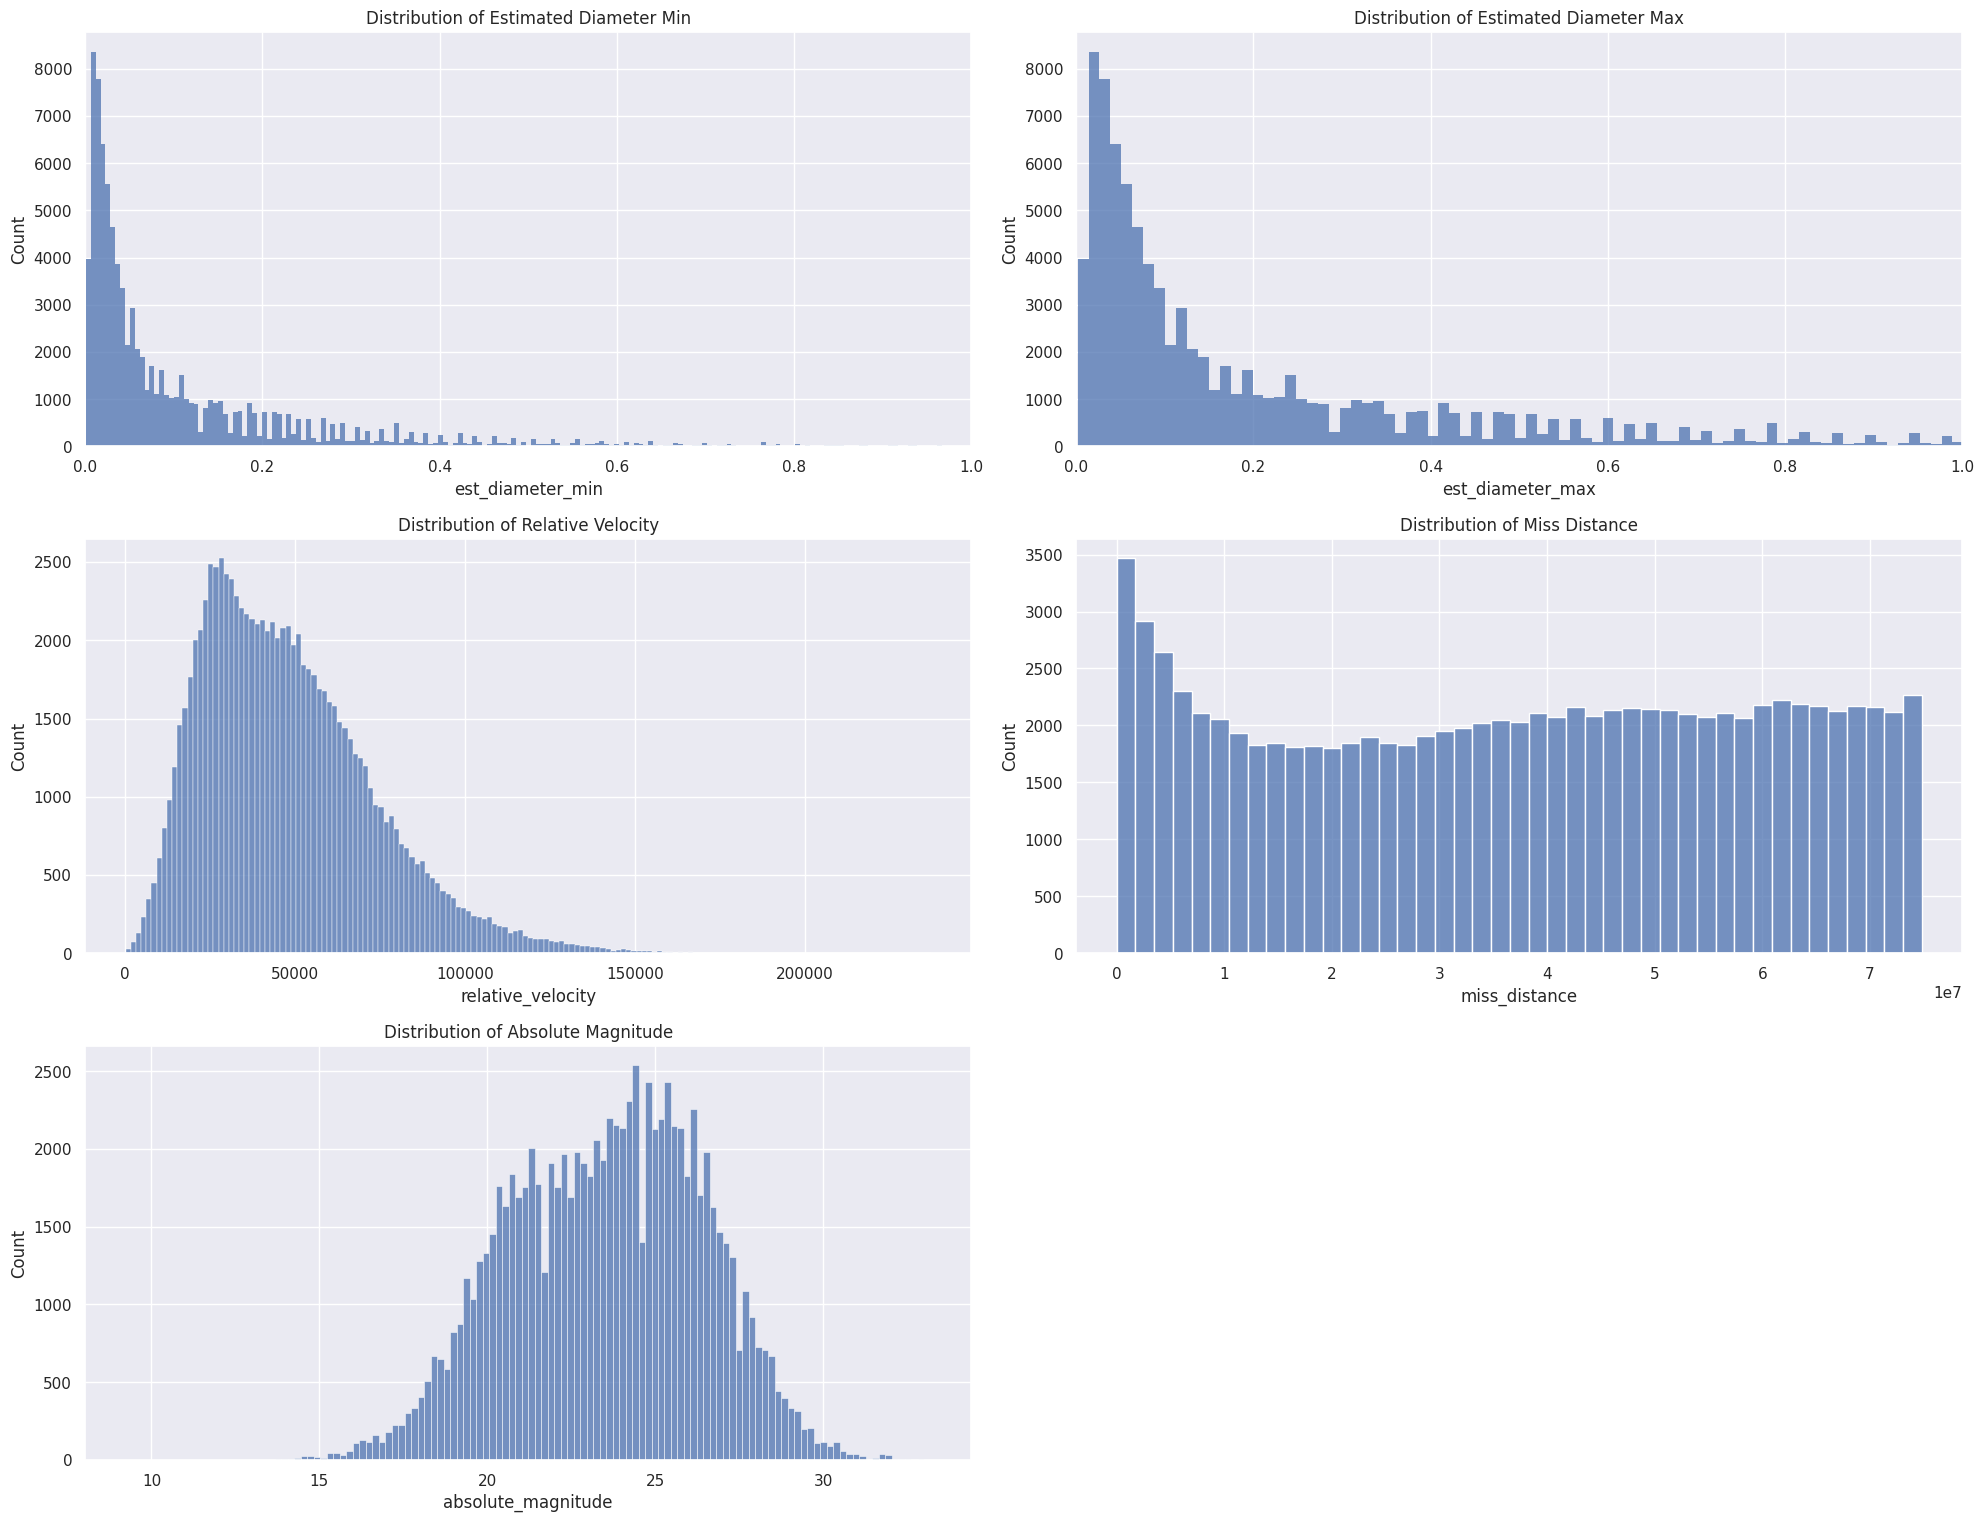

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 25))

sns.set(color_codes=True)

plt.subplot(5, 2, 1)
sns.histplot(data.est_diameter_min, kde=False)
plt.title('Distribution of Estimated Diameter Min')
plt.xlim(0, 1)


plt.subplot(5, 2, 2)
sns.histplot(data.est_diameter_max, kde=False)
plt.title('Distribution of Estimated Diameter Max')
plt.xlim(0, 1)


plt.subplot(5, 2, 3)
sns.histplot(data.relative_velocity, kde=False)
plt.title('Distribution of Relative Velocity')

plt.subplot(5, 2, 4)
sns.histplot(data.miss_distance, kde=False)
plt.title('Distribution of Miss Distance')

plt.subplot(5, 2, 5)
sns.histplot(data.absolute_magnitude, kde=False)
plt.title('Distribution of Absolute Magnitude')

plt.tight_layout()
plt.show()

## 1.5 Violin Plot

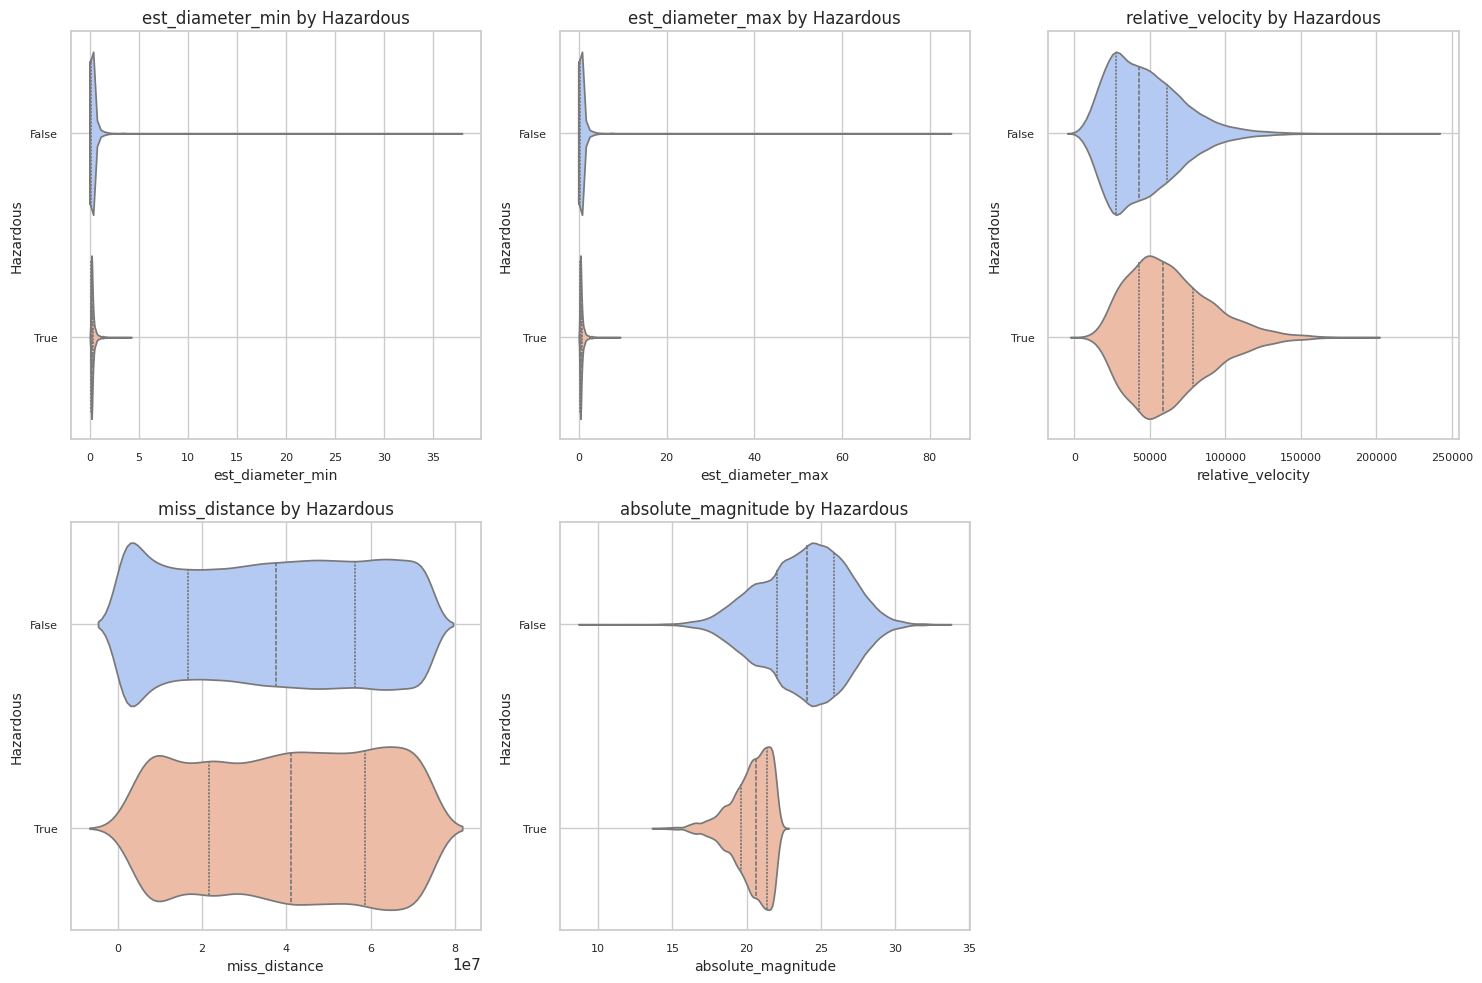

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de características
features = ['est_diameter_min', 'est_diameter_max',
            'relative_velocity', 'miss_distance',
            'absolute_magnitude']

# Estilo de seaborn
sns.set(style="whitegrid")

# Obtener la paleta 'coolwarm' de seaborn
palette = sns.color_palette("coolwarm", 2)

# Asignar los colores a las categorías
color_dict = {False: palette[0], True: palette[1]}

# Calcular el número de filas y columnas para la cuadrícula
n = len(features)
nrows = int(n**0.5)
ncols = (n + nrows - 1) // nrows

# Crear la figura y los subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()  # Aplanar el array de ejes para facilitar la iteración

# Crear los violin plots
for i, f in enumerate(features):
    ax = axes[i]
    sns.violinplot(data=data, x=f, y='hazardous', hue='hazardous',
                   orient='h', palette=color_dict, inner='quartile',
                   legend=False, ax=ax)
    ax.set_title(f'{f} by Hazardous', fontsize=12)
    ax.set_xlabel(f, fontsize=10)
    ax.set_ylabel('Hazardous', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

# Eliminar subplots vacíos si los hay
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 2 Pre-processing

In [ ]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Dividir los datos en entrenamiento, validación y prueba
# Conjunto de Entrenamiento: X_train, y_train (60% de los datos originales)
# Conjunto de Validación: X_val, y_val (20% de los datos originales)
# Conjunto de Prueba: X_test, y_test (20% de los datos originales)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20% del 100% para train
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42) #25% del 80% para validation, lo que equivale al 20% de los datos originales

# Calcular la precisión base en el conjunto de prueba
counters = collections.Counter(y_test)
labels = list(set(y_test))
if counters[labels[0]] > counters[labels[1]]:
    base_line_for_accuracy = counters[labels[0]] / len(y_test)
else:
    base_line_for_accuracy = counters[labels[1]] / len(y_test)
base_line_for_accuracy = round(base_line_for_accuracy, 3)
print("Base Accuracy: {}".format(str(base_line_for_accuracy)))

Base Accuracy: 0.905


In [ ]:
# Eliminar columnas no numéricas
columns_to_drop = ["id", "name", "orbiting_body", "sentry_object"]
X_train = X_train.drop(columns=columns_to_drop, errors='ignore')
X_val = X_val.drop(columns=columns_to_drop, errors='ignore')
X_test = X_test.drop(columns=columns_to_drop, errors='ignore')

In [ ]:
# Desbalanceo del dataset
minority_class_percent = 100 - round(sum(y) / len(y) * 100)
print("Minority class percentage: {}%".format(str(minority_class_percent)))

Minority class percentage: 90%


In [ ]:
# Resampling solo en el conjunto de entrenamiento
random_over_sampler = RandomOverSampler(random_state=42)
X_train, y_train = random_over_sampler.fit_resample(X_train, y_train)
minority_class_percent = 100 - round(sum(y_train) / len(y_train) * 100)
print("Minority class percentage after resampling: {}%".format(str(minority_class_percent)))


Minority class percentage after resampling: 50%


In [ ]:
# Imprimir la distribución de clases
def print_class_distribution(y_train, y_val, y_test):
    # Concatenar todos los conjuntos para obtener el total
    y_all = pd.concat([pd.Series(y_train), pd.Series(y_val), pd.Series(y_test)], axis=0)

    # Calcular los totales y porcentajes
    total_counts = y_all.value_counts()
    total_percentages = y_all.value_counts(normalize=True) * 100

    train_counts = pd.Series(y_train).value_counts()
    train_percentages = pd.Series(y_train).value_counts(normalize=True) * 100

    val_counts = pd.Series(y_val).value_counts()
    val_percentages = pd.Series(y_val).value_counts(normalize=True) * 100

    test_counts = pd.Series(y_test).value_counts()
    test_percentages = pd.Series(y_test).value_counts(normalize=True) * 100

    # Crear un DataFrame para mostrar los resultados
    df = pd.DataFrame({
        'Total Count': total_counts,
        'Total %': total_percentages,
        'Train Count': train_counts,
        'Train %': train_percentages,
        'Val Count': val_counts,
        'Val %': val_percentages,
        'Test Count': test_counts,
        'Test %': test_percentages
    }).fillna(0)  # Rellenar valores NaN con 0

    # Agregar una fila de totales
    df.loc['Total'] = df.sum(numeric_only=True)
    df.loc['Total', 'Total %'] = 100
    df.loc['Total', 'Train %'] = df.loc['Total', 'Train Count'] / df.loc['Total', 'Train Count'].sum() * 100
    df.loc['Total', 'Val %'] = df.loc['Total', 'Val Count'] / df.loc['Total', 'Val Count'].sum() * 100
    df.loc['Total', 'Test %'] = df.loc['Total', 'Test Count'] / df.loc['Total', 'Test Count'].sum() * 100

    print(df)

# Ejecutar la función
print_class_distribution(y_train, y_val, y_test)


           Total Count    Total %  Train Count  Train %  Val Count  \
hazardous                                                            
False          81996.0   60.93231      49117.0     50.0    16440.0   
True           52573.0   39.06769      49117.0     50.0     1727.0   
Total         134569.0  100.00000      98234.0    100.0    18167.0   

                Val %  Test Count      Test %  
hazardous                                      
False       90.493752     16439.0   90.483267  
True         9.506248      1729.0    9.516733  
Total      100.000000     18168.0  100.000000  


In [ ]:
# Escalado de características
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
# Preparación de datos
N_target = data['hazardous']
N_Features = data.drop(['hazardous'], axis=1)
Y = N_target
X = N_Features

# Transformación de la variable objetivo
def hazard(boolean):
    ''' Takes in numerical class, returns class state '''
    if boolean == False:
        return 'safe'
    else:
        return 'hazardous'

Y = Y.apply(hazard)
Y = np.array(Y)

# 3 Machine Learning Models

## 3.1 Logistic Regression (optimizado)

In [ ]:
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def run_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Escalar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Crear el modelo con los parámetros mejorados
    logreg = LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    logreg.fit(X_train_scaled, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = logreg.predict(X_val_scaled)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_lr = logreg.predict(X_test_scaled)
    cm_lr_classif = confusion_matrix(y_test, y_pred_lr)
    acc_lr_classif = round(accuracy_score(y_test, y_pred_lr), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_pred_lr), 3)
    recall = round(recall_score(y_test, y_pred_lr), 3)
    f1 = round(f1_score(y_test, y_pred_lr), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred_lr), 3)

    print("Confusion Matrix")
    print(cm_lr_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_lr_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [logreg, y_val_pred, acc_val, y_pred_lr, acc_lr_classif, cm_lr_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar la función
logreg_model, y_val_pred_lr, acc_val_lr, y_pred_lr, acc_lr_classif, cm_lr_classif, lr_precision, lr_recall, lr_f1, lr_roc_auc = run_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

Confusion Matrix
[[12408  4031]
 [   72  1657]]

Validation Set Accuracy: 0.777

Test Set Metrics:
Accuracy: 0.774
Precision: 0.291
Recall: 0.958
F1 Score: 0.447
ROC AUC: 0.857

Base Line Accuracy is: 0.905

Training time: 0.11 seconds
Validation time: 0.00 seconds
Testing time: 0.01 seconds


## 3.2 K-Nearest Neighbours (KNN)  (optimizado con método del codo)



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def run_knn_for_k_optimization(X_train, X_val, y_train, y_val, k):
    knn = KNeighborsClassifier(n_neighbors=k)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    knn.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = knn.predict(X_val)
    acc_val = accuracy_score(y_val_pred, y_val)
    end_val = time.time()
    val_time = end_val - start_val

    return acc_val

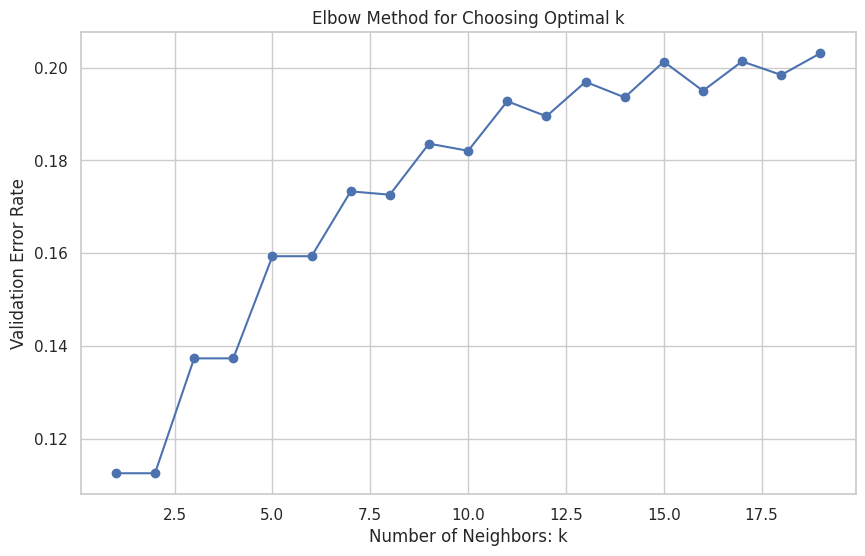

In [ ]:
# Evaluar el error para valores de k de 1 a 20
k_range = range(1, 20)
errors = []

for k in k_range:
    acc_val = run_knn_for_k_optimization(X_train, X_val, y_train, y_val, k)
    error = 1 - acc_val  # Calcular la tasa de error en el conjunto de validación
    errors.append(error)  # Añadir solo la tasa de error

# Visualizar resultados para el método del codo (Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(k_range, errors, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Choosing Optimal k')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Validation Error Rate')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_knn(X_train, X_val, X_test, y_train, y_val, y_test, k, base_acc):
    knn = KNeighborsClassifier(n_neighbors=k)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    knn.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = knn.predict(X_val)
    acc_val = round(accuracy_score(y_val_pred, y_val), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    knn_pred = knn.predict(X_test)
    cm_knn_classif = confusion_matrix(y_test, knn_pred)
    acc_knn_classif = round(accuracy_score(y_test, knn_pred), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, knn_pred), 3)
    recall = round(recall_score(y_test, knn_pred), 3)
    f1 = round(f1_score(y_test, knn_pred), 3)
    roc_auc = round(roc_auc_score(y_test, knn_pred), 3)

    print("Confusion Matrix")
    print(cm_knn_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_knn_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [knn, y_val_pred, acc_val, knn_pred, acc_knn_classif, cm_knn_classif[1][0], precision, recall, f1, roc_auc]

# Elegir el valor óptimo de k después de visualizar el método del codo
chosen_k = 5

# Ejecutar KNN con el valor de k elegido
knn_model, y_val_pred_knn, acc_val_knn, knn_pred, acc_knn_classif, cm_knn_classif, knn_precision, knn_recall, knn_f1, knn_roc_auc = run_knn(X_train, X_val, X_test, y_train, y_val, y_test, chosen_k, base_line_for_accuracy)


Confusion Matrix
[[14048  2391]
 [  471  1258]]

Validation Set Accuracy: 0.841

Test Set Metrics:
Accuracy: 0.842
Precision: 0.345
Recall: 0.728
F1 Score: 0.468
ROC AUC: 0.791

Base Line Accuracy is: 0.905

Training time: 0.09 seconds
Validation time: 0.96 seconds
Testing time: 1.05 seconds


## 3.3 Support Vector Machine (SVM) (optimizado)

In [ ]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_support_vector_machine(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Usar los mejores parámetros encontrados
    svm_classif = SVC(
        C=1,
        class_weight={0: 1, 1: 10},
        gamma='scale',
        kernel='rbf',
        random_state=42,
        probability=True
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    svm_classif.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = svm_classif.predict(X_val)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_svm = svm_classif.predict(X_test)
    cm_svm_classif = confusion_matrix(y_test, y_pred_svm)
    acc_svm_classif = round(accuracy_score(y_test, y_pred_svm), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_pred_svm), 3)
    recall = round(recall_score(y_test, y_pred_svm), 3)
    f1 = round(f1_score(y_test, y_pred_svm), 3)
    roc_auc = round(roc_auc_score(y_test, svm_classif.predict_proba(X_test)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_svm_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_svm_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [svm_classif, y_val_pred, acc_val, y_pred_svm, acc_svm_classif, cm_svm_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
svm_model, y_val_pred_svm, acc_val_svm, y_pred_svm, acc_svm_classif, cm_svm_classif, svm_precision, svm_recall, svm_f1, svm_roc_auc = run_support_vector_machine(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

Confusion Matrix
[[11449  4990]
 [    4  1725]]

Validation Set Accuracy: 0.728

Test Set Metrics:
Accuracy: 0.725
Precision: 0.257
Recall: 0.998
F1 Score: 0.409
ROC AUC: 0.889

Base Line Accuracy is: 0.905

Training time: 599.10 seconds
Validation time: 15.13 seconds
Testing time: 15.12 seconds


## 3.4 Decision Trees (optimizado)

In [ ]:
# Mejores parámetros: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_decision_tree(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Inicializar el DecisionTreeClassifier con los mejores parámetros
    best_dtc = DecisionTreeClassifier(
        class_weight=None,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    best_dtc.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = best_dtc.predict(X_val)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_dtc = best_dtc.predict(X_test)
    acc_dtc_classif = round(accuracy_score(y_test, y_pred_dtc), 3)
    cm_dtc_classif = confusion_matrix(y_test, y_pred_dtc)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales en el conjunto de prueba
    precision = round(precision_score(y_test, y_pred_dtc), 3)
    recall = round(recall_score(y_test, y_pred_dtc), 3)
    f1 = round(f1_score(y_test, y_pred_dtc), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred_dtc), 3)

    print("Confusion Matrix")
    print(cm_dtc_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_dtc_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [best_dtc, y_val_pred, acc_val, y_pred_dtc, acc_dtc_classif, cm_dtc_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
dtc_model, y_val_pred_dtc, acc_val_dtc, y_pred_dtc, acc_dtc_classif, cm_dtc_classif, dtc_precision, dtc_recall, dtc_f1, dtc_roc_auc = run_decision_tree(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)


Confusion Matrix
[[15472   967]
 [  966   763]]

Validation Set Accuracy: 0.895

Test Set Metrics:
Accuracy: 0.894
Precision: 0.441
Recall: 0.441
F1 Score: 0.441
ROC AUC: 0.691

Base Line Accuracy is: 0.905

Training time: 0.46 seconds
Validation time: 0.00 seconds
Testing time: 0.01 seconds


## 3.5 Gaussian Naive Bayes (optimizado)

In [ ]:
# Mejores parámetros: var_smoothing=1.0
import time
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def run_naive_bayes(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Escalar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Aplicar SMOTE para manejar el desbalance de clases
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Crear el modelo con el mejor var_smoothing encontrado
    nb_classif = GaussianNB(var_smoothing=1.0)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    nb_classif.fit(X_train_resampled, y_train_resampled)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = nb_classif.predict(X_val_scaled)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_nb_pred = nb_classif.predict(X_test_scaled)
    cm_nb_classif = confusion_matrix(y_test, y_nb_pred)
    acc_nb_classif = round(accuracy_score(y_test, y_nb_pred), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_nb_pred), 3)
    recall = round(recall_score(y_test, y_nb_pred), 3)
    f1 = round(f1_score(y_test, y_nb_pred), 3)
    roc_auc = round(roc_auc_score(y_test, nb_classif.predict_proba(X_test_scaled)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_nb_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_nb_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [nb_classif, y_val_pred, acc_val, y_nb_pred, acc_nb_classif, cm_nb_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
nb_model, y_val_pred_nb, acc_val_nb, y_nb_pred, acc_nb_classif, cm_nb_classif, nb_precision, nb_recall, nb_f1, nb_roc_auc = run_naive_bayes(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

Confusion Matrix
[[12320  4119]
 [  170  1559]]

Validation Set Accuracy: 0.767

Test Set Metrics:
Accuracy: 0.764
Precision: 0.275
Recall: 0.902
F1 Score: 0.421
ROC AUC: 0.863

Base Line Accuracy is: 0.905

Training time: 0.02 seconds
Validation time: 0.00 seconds
Testing time: 0.01 seconds


# 4 Enssemble Models

## 4.1 Random Forest (optimizado)


In [ ]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_random_forest(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Usar los mejores parámetros encontrados
    rf_classif = RandomForestClassifier(
        n_estimators=500,
        criterion='gini',
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        bootstrap=True,
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    rf_classif.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = rf_classif.predict(X_val)
    acc_val = round(accuracy_score(y_val_pred, y_val), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_rf = rf_classif.predict(X_test)
    cm_rf_classif = confusion_matrix(y_test, y_pred_rf)
    acc_rf_classif = round(accuracy_score(y_test, y_pred_rf), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_pred_rf), 3)
    recall = round(recall_score(y_test, y_pred_rf), 3)
    f1 = round(f1_score(y_test, y_pred_rf), 3)
    roc_auc = round(roc_auc_score(y_test, rf_classif.predict_proba(X_test)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_rf_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_rf_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [rf_classif, y_val_pred, acc_val, y_pred_rf, acc_rf_classif, cm_rf_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
rf_model, y_val_pred_rf, acc_val_rf, y_pred_rf, acc_rf_classif, cm_rf_classif, rf_precision, rf_recall, rf_f1, rf_roc_auc = run_random_forest(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)


Confusion Matrix
[[13475  2964]
 [  187  1542]]

Validation Set Accuracy: 0.829

Test Set Metrics:
Accuracy: 0.827
Precision: 0.342
Recall: 0.892
F1 Score: 0.495
ROC AUC: 0.922

Base Line Accuracy is: 0.905

Training time: 59.05 seconds
Validation time: 0.82 seconds
Testing time: 0.82 seconds


## 4.2 Voting Classifier

In [ ]:
import time
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_voting_classifier(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Crear el Voting Classifier reutilizando los modelos ya existentes
    voting_clf = VotingClassifier(
        estimators=[
            ('lr', logreg_model),
            ('knn', knn_model),
            ('svm', svm_model),
            ('dt', dtc_model),
            ('nb', nb_model),
            ('rf', rf_model)
        ],
        voting='hard'
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    voting_clf.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = voting_clf.predict(X_val)
    acc_val = round(accuracy_score(y_val_pred, y_val), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_voting = voting_clf.predict(X_test)
    cm_voting = confusion_matrix(y_test, y_pred_voting)
    acc_voting = round(accuracy_score(y_test, y_pred_voting), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_pred_voting), 3)
    recall = round(recall_score(y_test, y_pred_voting), 3)
    f1 = round(f1_score(y_test, y_pred_voting), 3)
    roc_auc = round(roc_auc_score(y_test, y_pred_voting), 3)

    print("Confusion Matrix")
    print(cm_voting)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_voting}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [voting_clf, y_val_pred, acc_val, y_pred_voting, acc_voting, cm_voting[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
voting_model, y_val_pred_voting, acc_val_voting, y_pred_voting, acc_voting, cm_voting, voting_precision, voting_recall, voting_f1, voting_roc_auc = run_voting_classifier(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

Confusion Matrix
[[13160  3279]
 [  141  1588]]

Validation Set Accuracy: 0.812

Test Set Metrics:
Accuracy: 0.812
Precision: 0.326
Recall: 0.918
F1 Score: 0.482
ROC AUC: 0.859

Base Line Accuracy is: 0.905

Training time: 656.75 seconds
Validation time: 17.00 seconds
Testing time: 17.08 seconds


# 5 Boosting

## 5.1 Gradient Boosting (optimizado)



In [ ]:
# Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}

import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_gradient_boosting(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Usar los mejores parámetros encontrados
    gb_classif = GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=500,
        subsample=0.8,
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    gb_classif.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = gb_classif.predict(X_val)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_gb_pred = gb_classif.predict(X_test)
    cm_gb_classif = confusion_matrix(y_test, y_gb_pred)
    acc_gb_classif = round(accuracy_score(y_test, y_gb_pred), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_gb_pred), 3)
    recall = round(recall_score(y_test, y_gb_pred), 3)
    f1 = round(f1_score(y_test, y_gb_pred), 3)
    roc_auc = round(roc_auc_score(y_test, gb_classif.predict_proba(X_test)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_gb_classif)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_gb_classif}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [gb_classif, y_val_pred, acc_val, y_gb_pred, acc_gb_classif, cm_gb_classif[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
gb_model, y_val_pred_gb, acc_val_gb, y_gb_pred, acc_gb_classif, cm_gb_classif, gb_precision, gb_recall, gb_f1, gb_roc_auc = run_gradient_boosting(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)


Confusion Matrix
[[13472  2967]
 [  154  1575]]

Validation Set Accuracy: 0.831

Test Set Metrics:
Accuracy: 0.828
Precision: 0.347
Recall: 0.911
F1 Score: 0.502
ROC AUC: 0.929

Base Line Accuracy is: 0.905

Training time: 102.43 seconds
Validation time: 0.13 seconds
Testing time: 0.13 seconds


## 5.2 AdaBoost (optimizado)

In [ ]:
# Mejores parámetros:  {'learning_rate': 0.01, 'n_estimators': 200}

import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_adaboost(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Inicializar AdaBoostClassifier con los mejores parámetros
    ada_clf = AdaBoostClassifier(learning_rate=0.01, n_estimators=200, random_state=42)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    ada_clf.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = ada_clf.predict(X_val)
    acc_val = round(accuracy_score(y_val_pred, y_val), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_ada_pred = ada_clf.predict(X_test)
    cm_ada = confusion_matrix(y_test, y_ada_pred)
    acc_ada = round(accuracy_score(y_test, y_ada_pred), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_ada_pred), 3)
    recall = round(recall_score(y_test, y_ada_pred), 3)
    f1 = round(f1_score(y_test, y_ada_pred), 3)
    roc_auc = round(roc_auc_score(y_test, ada_clf.predict_proba(X_test)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_ada)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_ada}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [ada_clf, y_val_pred, acc_val, y_ada_pred, acc_ada, cm_ada[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
ada_model, y_val_pred_ada, acc_val_ada, y_ada_pred, acc_ada, cm_ada, ada_precision, ada_recall, ada_f1, ada_roc_auc = run_adaboost(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

Confusion Matrix
[[12279  4160]
 [    8  1721]]

Validation Set Accuracy: 0.774

Test Set Metrics:
Accuracy: 0.771
Precision: 0.293
Recall: 0.995
F1 Score: 0.452
ROC AUC: 0.9

Base Line Accuracy is: 0.905

Training time: 13.95 seconds
Validation time: 0.34 seconds
Testing time: 0.34 seconds


##5.3 XGBoost  (optimizado)

In [ ]:
# Mejores parámetros:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}

import time
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_xgboost_classifier(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Encode target variables
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and fit the XGBClassifier with best parameters
    xgb = XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=7,
        n_estimators=300,
        subsample=1.0,
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    xgb.fit(X_train_scaled, y_train_encoded)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred_xgb = xgb.predict(X_val_scaled)
    acc_val = round(accuracy_score(y_val_encoded, y_val_pred_xgb), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_xgb = xgb.predict(X_test_scaled)
    cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
    acc_xgb = round(accuracy_score(y_test_encoded, y_pred_xgb), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test_encoded, y_pred_xgb), 3)
    recall = round(recall_score(y_test_encoded, y_pred_xgb), 3)
    f1 = round(f1_score(y_test_encoded, y_pred_xgb), 3)
    roc_auc = round(roc_auc_score(y_test_encoded, xgb.predict_proba(X_test_scaled)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_xgb)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_xgb}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [xgb, y_val_pred_xgb, acc_val, y_pred_xgb, acc_xgb, cm_xgb[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
xgb_model, y_val_pred_xgb, acc_val_xgb, y_pred_xgboost, acc_xgboost_classif, cm_xgboost_classif, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc = run_xgboost_classifier(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)


Confusion Matrix
[[13488  2951]
 [  221  1508]]

Validation Set Accuracy: 0.826

Test Set Metrics:
Accuracy: 0.825
Precision: 0.338
Recall: 0.872
F1 Score: 0.487
ROC AUC: 0.923

Base Line Accuracy is: 0.905

Training time: 0.60 seconds
Validation time: 0.02 seconds
Testing time: 0.03 seconds


##5.4 NGBoost  (optimizado)

In [ ]:
# Mejores parámetros: {'Base__max_depth': 3, 'learning_rate': 0.01, 'minibatch_frac': 1.0, 'n_estimators': 500}

!pip install -q ngboost
import time
import numpy as np
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def run_ngboost(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Crear nuevas variables de etiquetas en formato entero binario
    y_train_int = y_train.astype(int)
    y_val_int = y_val.astype(int)
    y_test_int = y_test.astype(int)

    # Inicializar y ajustar el NGBClassifier con los mejores parámetros
    ngb = NGBClassifier(
        Dist=Bernoulli,
        random_state=42,
        n_estimators=500,
        learning_rate=0.01,
        minibatch_frac=1.0,
        Base=DecisionTreeRegressor(max_depth=3),
        verbose=True
    )

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    ngb.fit(X_train_scaled, y_train_int, X_val=X_val_scaled, Y_val=y_val_int)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = ngb.predict(X_val_scaled)
    acc_val = round(accuracy_score(y_val_int, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Evaluación en el conjunto de prueba
    start_test = time.time()
    y_pred_ngb = ngb.predict(X_test_scaled)
    cm_ngb = confusion_matrix(y_test_int, y_pred_ngb)
    acc_ngb = round(accuracy_score(y_test_int, y_pred_ngb), 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test_int, y_pred_ngb), 3)
    recall = round(recall_score(y_test_int, y_pred_ngb), 3)
    f1 = round(f1_score(y_test_int, y_pred_ngb), 3)

    # Obtener las probabilidades predichas para la clase positiva (p1) para la puntuación ROC AUC
    pred_probs = ngb.pred_dist(X_test_scaled).params['p1']
    roc_auc = round(roc_auc_score(y_test_int, pred_probs), 3)

    print("Confusion Matrix")
    print(cm_ngb)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_ngb}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [ngb, y_val_pred, acc_val, y_pred_ngb, acc_ngb, cm_ngb[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
ngb_model, y_val_pred_ngb, acc_val_ngb, y_pred_ngb, acc_ngb, cm_ngb, ngb_precision, ngb_recall, ngb_f1, ngb_roc_auc = run_ngboost(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 63.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
[iter 0] loss=0.6931 val_loss=0.6691 scale=4.0000 norm=8.0000
[iter 100] loss=0.3011 val_loss=0.3607 scale=4.0000 norm=6.2928
[iter 200] loss=0.2954 val_loss=0.3588 scale=2.0000 norm=3.1734
[iter 300] loss=0.2945 val_loss=0.3583 scale=2.0000 norm=3.1761
[iter 400] loss=0.2941 val_loss=0.3582 scale=0.5000 norm=0.7944
Confusion Matrix
[[12504  3935]

# Comparison

Logistic Regression:
  AUC: 0.87
  Max TPR/FPR: inf
  At threshold: 1.9602
  TPR at this point: 0.0000
  FPR at this point: 0.0000

K-Nearest Neighbors (KNN):
  AUC: 0.85
  Max TPR/FPR: inf
  At threshold: 2.0000
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Support Vector Machine (SVM):
  AUC: 0.89
  Max TPR/FPR: inf
  At threshold: 1.9851
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Decision Trees:
  AUC: 0.69
  Max TPR/FPR: inf
  At threshold: 2.0000
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Gaussian Naive Bayes:
  AUC: 0.86
  Max TPR/FPR: inf
  At threshold: 2.0000
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Random Forest:
  AUC: 0.92
  Max TPR/FPR: inf
  At threshold: 2.0000
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Voting Classifier:
  AUC: 0.86
  Max TPR/FPR: inf
  At threshold: 2.0000
  TPR at this point: 0.0000
  FPR at this point: 0.0000

Gradient Boosting:
  AUC: 0.93
  Max TPR/FPR: inf
  At threshold: 1.9973


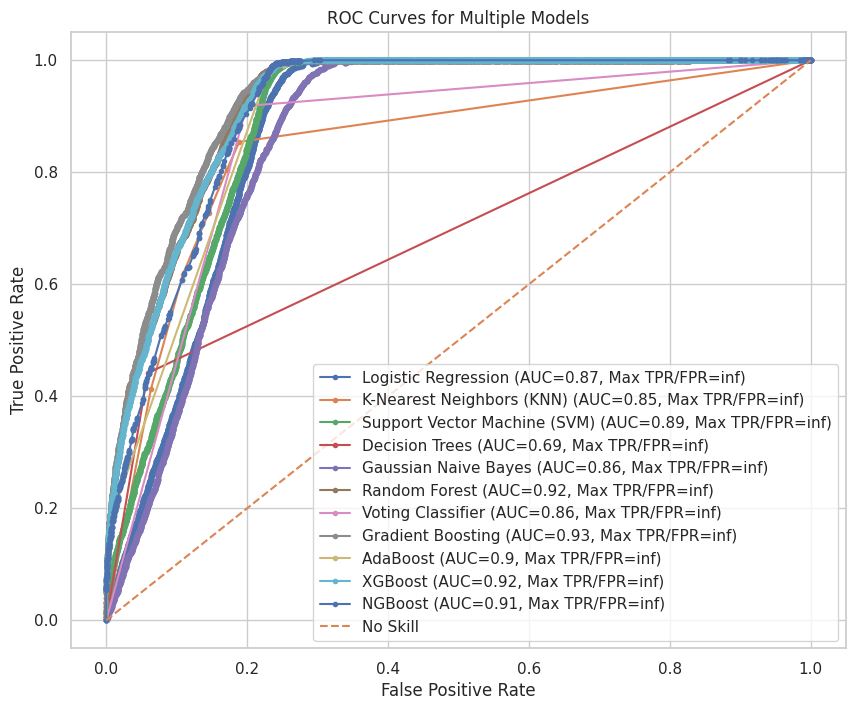

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def trazar_varias_curvas_titulos(models, testX, testy, model_names):
    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        if hasattr(model, "predict_proba"):
            model_probs = model.predict_proba(testX)[:, 1]
        else:
            # For models without predict_proba, use decision_function if available
            # otherwise, use the raw predictions
            if hasattr(model, "decision_function"):
                model_probs = model.decision_function(testX)
            else:
                model_probs = model.predict(testX)

        # Calcular AUC
        model_auc = round(roc_auc_score(testy, model_probs), 2)

        # Calcular TPR y FPR
        model_fpr, model_tpr, model_thr = roc_curve(testy, model_probs)

        # Calcular TPR/FPR
        with np.errstate(divide='ignore', invalid='ignore'):
            tpr_fpr_ratio = np.where(model_fpr != 0, model_tpr / model_fpr, np.inf)

        # Encontrar el punto donde TPR/FPR es máximo
        max_ratio_index = np.nanargmax(tpr_fpr_ratio)
        max_tpr_fpr_ratio = tpr_fpr_ratio[max_ratio_index]

        model_title = '{} (AUC={}, Max TPR/FPR={:.2f})'.format(model_names[i], model_auc, max_tpr_fpr_ratio)
        plt.plot(model_fpr, model_tpr, marker='.', label=model_title)

        print(f"{model_names[i]}:")
        print(f"  AUC: {model_auc}")
        print(f"  Max TPR/FPR: {max_tpr_fpr_ratio:.2f}")
        print(f"  At threshold: {model_thr[max_ratio_index]:.4f}")
        print(f"  TPR at this point: {model_tpr[max_ratio_index]:.4f}")
        print(f"  FPR at this point: {model_fpr[max_ratio_index]:.4f}")
        print("")

    # Clasificador de referencia (No Skill)
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

# Create a list with the trained models
models = [logreg_model, knn_model, svm_model, dtc_model, nb_model, rf_model, voting_model, gb_model, ada_model, xgb_model, ngb_model]

# Create a list with the model names
model_names = ["Logistic Regression", "K-Nearest Neighbors (KNN)", "Support Vector Machine (SVM)",
"Decision Trees", "Gaussian Naive Bayes", "Random Forest",
"Voting Classifier", "Gradient Boosting", "AdaBoost", "XGBoost", "NGBoost"]

# Call the function to plot ROC curves and calculate metrics
trazar_varias_curvas_titulos(models, X_test, y_test, model_names)

Logistic Regression:
  AUC: 0.87
  Best TPR/FPR: 21.39
  TPR at this point: 0.0052
  FPR at this point: 0.0002
  At threshold: 0.9515

K-Nearest Neighbors (KNN):
  AUC: 0.85
  Best TPR/FPR: 6.50
  TPR at this point: 0.4130
  FPR at this point: 0.0635
  At threshold: 1.0000

Support Vector Machine (SVM):
  AUC: 0.89
  Best TPR/FPR: 190.16
  TPR at this point: 0.0116
  FPR at this point: 0.0001
  At threshold: 0.9737

Decision Trees:
  AUC: 0.69
  Best TPR/FPR: 7.50
  TPR at this point: 0.4413
  FPR at this point: 0.0588
  At threshold: 1.0000

Gaussian Naive Bayes:
  AUC: 0.86
  Best TPR/FPR: 3.92
  TPR at this point: 0.6761
  FPR at this point: 0.1723
  At threshold: 0.6013

Random Forest:
  AUC: 0.92
  Best TPR/FPR: 494.41
  TPR at this point: 0.0301
  FPR at this point: 0.0001
  At threshold: 0.9955

Voting Classifier:
  AUC: 0.86
  Best TPR/FPR: 4.60
  TPR at this point: 0.9184
  FPR at this point: 0.1995
  At threshold: 1.0000

Gradient Boosting:
  AUC: 0.93
  Best TPR/FPR: 865.21


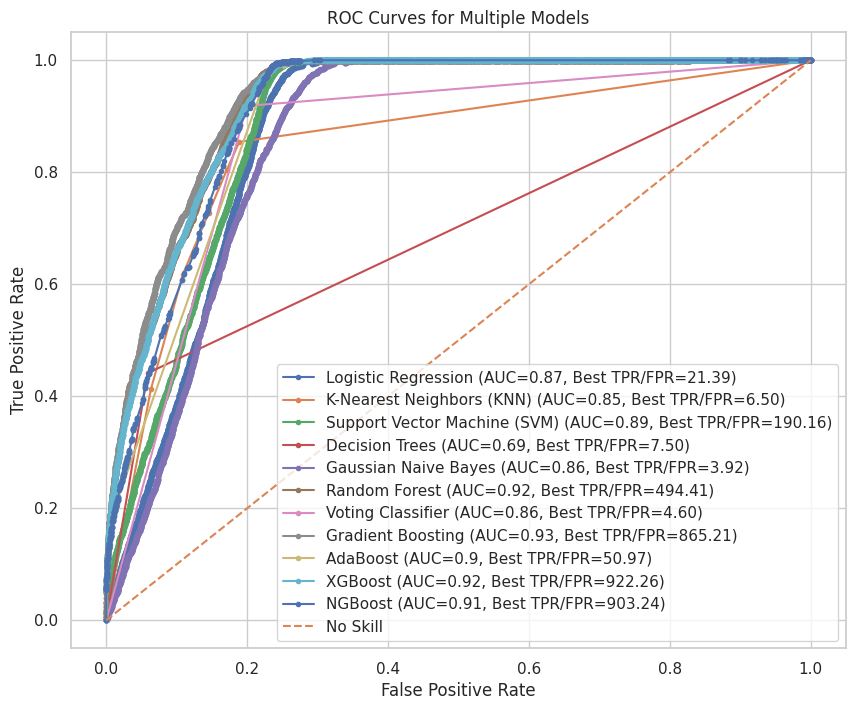

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def trazar_varias_curvas_titulos(models, testX, testy, model_names):
    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        if hasattr(model, "predict_proba"):
            model_probs = model.predict_proba(testX)[:, 1]
        else:
            if hasattr(model, "decision_function"):
                model_probs = model.decision_function(testX)
            else:
                model_probs = model.predict(testX)

        # Calcular AUC
        model_auc = round(roc_auc_score(testy, model_probs), 2)

        # Calcular TPR y FPR
        model_fpr, model_tpr, model_thr = roc_curve(testy, model_probs)

        # Calcular TPR/FPR ratio, excluyendo puntos donde FPR es 0
        with np.errstate(divide='ignore', invalid='ignore'):
            tpr_fpr_ratio = np.where(model_fpr != 0, model_tpr / model_fpr, np.nan)

        # Encontrar el punto donde TPR/FPR es máximo (excluyendo infinito)
        best_idx = np.nanargmax(tpr_fpr_ratio)
        best_tpr = model_tpr[best_idx]
        best_fpr = model_fpr[best_idx]
        best_ratio = tpr_fpr_ratio[best_idx]
        best_threshold = model_thr[best_idx]

        model_title = '{} (AUC={}, Best TPR/FPR={:.2f})'.format(
            model_names[i], model_auc, best_ratio)
        plt.plot(model_fpr, model_tpr, marker='.', label=model_title)

        print(f"{model_names[i]}:")
        print(f"  AUC: {model_auc}")
        print(f"  Best TPR/FPR: {best_ratio:.2f}")
        print(f"  TPR at this point: {best_tpr:.4f}")
        print(f"  FPR at this point: {best_fpr:.4f}")
        print(f"  At threshold: {best_threshold:.4f}")
        print("")

    # Clasificador de referencia (No Skill)
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

# Create a list with the trained models
models = [logreg_model, knn_model, svm_model, dtc_model, nb_model, rf_model, voting_model, gb_model, ada_model, xgb_model, ngb_model]

# Create a list with the model names
model_names = ["Logistic Regression", "K-Nearest Neighbors (KNN)", "Support Vector Machine (SVM)",
"Decision Trees", "Gaussian Naive Bayes", "Random Forest",
"Voting Classifier", "Gradient Boosting", "AdaBoost", "XGBoost", "NGBoost"]

# Call the function to plot ROC curves and calculate metrics
trazar_varias_curvas_titulos(models, X_test, y_test, model_names)

In [ ]:
# Crear un DataFrame para recopilar los resultados de los modelos
results = {
    'Modelo': [
        'Base Line Accuracy', 'Logistic Regression', 'K-Nearest Neighbors (KNN)', 'Support Vector Machine (SVM)',
        'Decision Trees', 'Gaussian Naive Bayes', 'Random Forest',
        'Voting Classifier', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'NGBoost'
    ],
    'Precisión (Accuracy)': [
        base_line_for_accuracy, acc_lr_classif, acc_knn_classif, acc_svm_classif,
        acc_dtc_classif, acc_nb_classif, acc_rf_classif,
        acc_voting, acc_gb_classif, acc_ada, acc_xgboost_classif, acc_ngb
    ],
    'Precisión': [
        None, lr_precision, knn_precision, svm_precision,
        dtc_precision, nb_precision, rf_precision,
        voting_precision, gb_precision, ada_precision, xgb_precision, ngb_precision
    ],
    'Recall': [
        None, lr_recall, knn_recall, svm_recall,
        dtc_recall, nb_recall, rf_recall,
        voting_recall, gb_recall, ada_recall, xgb_recall, ngb_recall
    ],
    'F1 Score': [
        None, lr_f1, knn_f1, svm_f1,
        dtc_f1, nb_f1, rf_f1,
        voting_f1, gb_f1, ada_f1, xgb_f1, ngb_f1
    ],
    'ROC AUC': [
        None, lr_roc_auc, knn_roc_auc, svm_roc_auc,
        dtc_roc_auc, nb_roc_auc, rf_roc_auc,
        voting_roc_auc, gb_roc_auc, ada_roc_auc, xgb_roc_auc, ngb_roc_auc
    ]
}

# Convertir el diccionario en un DataFrame de pandas
df_results = pd.DataFrame(results)

# Mostrar el DataFrame
print(df_results)


                          Modelo  Precisión (Accuracy)  Precisión  Recall  \
0             Base Line Accuracy                 0.905        NaN     NaN   
1            Logistic Regression                 0.774      0.291   0.958   
2      K-Nearest Neighbors (KNN)                 0.842      0.345   0.728   
3   Support Vector Machine (SVM)                 0.725      0.257   0.998   
4                 Decision Trees                 0.894      0.441   0.441   
5           Gaussian Naive Bayes                 0.764      0.275   0.902   
6                  Random Forest                 0.827      0.342   0.892   
7              Voting Classifier                 0.812      0.326   0.918   
8              Gradient Boosting                 0.828      0.347   0.911   
9                       AdaBoost                 0.771      0.293   0.995   
10                       XGBoost                 0.825      0.338   0.872   
11                       NGBoost                 0.783      0.304   0.992   

# 6 Deep Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Usar CUDA si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover datos a dispositivo
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


## 6.1 Multi Layer Perceptron

In [ ]:
import time
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def run_mlp(X_train, X_val, X_test, y_train, y_val, y_test, base_acc):
    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Inicializar y entrenar el MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                        solver='adam', random_state=42, learning_rate_init=0.001)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    mlp.fit(X_train_scaled, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    y_val_pred = mlp.predict(X_val_scaled)
    acc_val = round(accuracy_score(y_val, y_val_pred), 3)
    end_val = time.time()
    val_time = end_val - start_val

    # Predecir y evaluar los resultados
    start_test = time.time()
    y_pred_mlp = mlp.predict(X_test_scaled)
    cm_mlp = confusion_matrix(y_test, y_pred_mlp)
    acc_mlp = accuracy_score(y_test, y_pred_mlp)
    acc_mlp = round(acc_mlp, 3)
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular métricas adicionales
    precision = round(precision_score(y_test, y_pred_mlp), 3)
    recall = round(recall_score(y_test, y_pred_mlp), 3)
    f1 = round(f1_score(y_test, y_pred_mlp), 3)
    roc_auc = round(roc_auc_score(y_test, mlp.predict_proba(X_test_scaled)[:, 1]), 3)

    print("Confusion Matrix")
    print(cm_mlp)
    print()
    print(f"Validation Set Accuracy: {acc_val}")
    print()
    print("Test Set Metrics:")
    print(f"Accuracy: {acc_mlp}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return [mlp, y_val_pred, acc_val, y_pred_mlp, acc_mlp, cm_mlp[1][0], precision, recall, f1, roc_auc]

# Ejecutar el modelo
mlp_model, y_val_pred_mlp, acc_val_mlp, y_pred_mlp, acc_mlp, cm_mlp, mlp_precision, mlp_recall, mlp_f1, mlp_roc_auc = run_mlp(X_train, X_val, X_test, y_train, y_val, y_test, base_line_for_accuracy)


Confusion Matrix
[[12601  3838]
 [   22  1707]]

Validation Set Accuracy: 0.789

Test Set Metrics:
Accuracy: 0.788
Precision: 0.308
Recall: 0.987
F1 Score: 0.469
ROC AUC: 0.911

Base Line Accuracy is: 0.905

Training time: 33.37 seconds
Validation time: 0.02 seconds
Testing time: 0.02 seconds


## 6.2 Multi Layer Perceptron con CUDA

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def run_mlp(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, base_acc):
    input_size = X_train_tensor.shape[1]
    hidden_size = 100
    num_classes = len(torch.unique(y_train_tensor))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_size, hidden_size, num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

    num_epochs = 300
    best_accuracy = 0
    best_epoch = 0

    start_train = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step(running_loss)

        if epoch - best_epoch > 20:
            print("Early stopping")
            break

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}')

    end_train = time.time()
    train_time = end_train - start_train

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    start_test = time.time()
    with torch.no_grad():
        inputs, labels = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_accuracy = (predicted == labels).sum().item() / labels.size(0)

        cm_mlp = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
        precision = round(precision_score(labels.cpu().numpy(), predicted.cpu().numpy()), 3)
        recall = round(recall_score(labels.cpu().numpy(), predicted.cpu().numpy()), 3)
        f1 = round(f1_score(labels.cpu().numpy(), predicted.cpu().numpy()), 3)
        roc_auc = round(roc_auc_score(labels.cpu().numpy(), outputs.softmax(dim=1)[:, 1].cpu().numpy()), 3)

    end_test = time.time()
    test_time = end_test - start_test

    print("Confusion Matrix")
    print(cm_mlp)
    print()
    print(f"Validation Set Accuracy: N/A")
    print(f"Test Set Accuracy: {test_accuracy:.3f}")
    print(f"Test Set Precision: {precision}")
    print(f"Test Set Recall: {recall}")
    print(f"Test Set F1 Score: {f1}")
    print(f"Test Set ROC AUC: {roc_auc}")
    print()
    print(f"Base Line Accuracy is: {base_acc}")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return model, predicted.cpu().numpy(), test_accuracy, cm_mlp, precision, recall, f1, roc_auc

# Ejecución del entrenamiento y evaluación
mlp_model_cuda, preds_cuda, acc_cuda, cm_cuda, precision_cuda, recall_cuda, f1_cuda, roc_auc_cuda = run_mlp(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, base_line_for_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/300, Loss: 146.2825, Accuracy: 0.8474
Epoch 2/300, Loss: 123.6451, Accuracy: 0.8700
Epoch 3/300, Loss: 119.3397, Accuracy: 0.8738
Epoch 4/300, Loss: 117.3078, Accuracy: 0.8747
Epoch 5/300, Loss: 116.1715, Accuracy: 0.8757
Epoch 6/300, Loss: 115.3913, Accuracy: 0.8765
Epoch 7/300, Loss: 114.9615, Accuracy: 0.8763
Epoch 8/300, Loss: 114.5828, Accuracy: 0.8767
Epoch 9/300, Loss: 114.4297, Accuracy: 0.8766
Epoch 10/300, Loss: 114.2425, Accuracy: 0.8769
Epoch 11/300, Loss: 114.0197, Accuracy: 0.8768
Epoch 12/300, Loss: 113.9304, Accuracy: 0.8767
Epoch 13/300, Loss: 113.8434, Accuracy: 0.8767
Epoch 14/300, Loss: 113.7440, Accuracy: 0.8768
Epoch 15/300, Loss: 113.6738, Accuracy: 0.8769
Epoch 16/300, Loss: 113.6721, Accuracy: 0.8770
Epoch 17/300, Loss: 113.5601, Accuracy: 0.8770
Epoch 18/300, Loss: 113.5133, Accuracy: 0.8769
Epoch 19/300, Loss: 113.4024, Accuracy: 0.8771
Epoch 20/300, Loss: 113.4089, Accuracy: 0.8771
Epoch 21/300, Loss: 113.3596, Accuracy: 0.8772
Epoch 22/300, Loss: 11

## 6.3 Transformers

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def run_transformer(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, base_line_for_accuracy):
    # DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection to trace NaN values

    class TransformerModel(nn.Module):
        def __init__(self, input_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate, num_classes):
            super(TransformerModel, self).__init__()
            self.embedding = nn.Linear(input_dim, ff_dim)
            transformer_layer = nn.TransformerEncoderLayer(d_model=ff_dim, nhead=num_heads, dropout=dropout_rate, batch_first=True)
            self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_transformer_blocks)
            self.output_layer = nn.Linear(ff_dim, num_classes)
            self.dropout = nn.Dropout(dropout_rate)
            self.apply(init_weights)  # Apply custom weight initialization

        def forward(self, x):
            x = self.embedding(x)
            x = x.view(x.size(0), 1, -1)
            x = self.transformer(x)
            x = x.mean(dim=1)
            x = self.dropout(x)
            x = self.output_layer(x)
            return x

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    model = TransformerModel(input_dim=X_train_tensor.shape[1], num_heads=8, ff_dim=128, num_transformer_blocks=6, dropout_rate=0.2, num_classes=len(set(y_train_tensor.tolist())))
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    num_epochs = 50
    best_val_accuracy = 0.0
    best_epoch = 0

    start_train = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        if epoch_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')

        # Early stopping condition
        if epoch - best_epoch > 20:
            print("Early stopping")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    end_train = time.time()
    train_time = end_train - start_train

    # Validación
    start_val = time.time()
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = 100 * val_correct / val_total
    end_val = time.time()
    val_time = end_val - start_val

    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Cargar el mejor modelo y evaluar en el conjunto de prueba
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    start_test = time.time()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    end_test = time.time()
    test_time = end_test - start_test

    # Calcular matriz de confusión y métricas adicionales
    cm = confusion_matrix(all_labels, all_preds)
    precision = round(precision_score(all_labels, all_preds), 3)
    recall = round(recall_score(all_labels, all_preds), 3)
    f1 = round(f1_score(all_labels, all_preds), 3)
    roc_auc = round(roc_auc_score(all_labels, model(X_test_tensor.clone().detach().to(device)).softmax(dim=1).detach().cpu().numpy()[:, 1]), 3)

    # Mostrar resultados
    print("Confusion Matrix")
    print(cm)
    print()
    print(f"Test Set Accuracy: {test_accuracy:.2f}%")
    print(f"Test Set Precision: {precision}")
    print(f"Test Set Recall: {recall}")
    print(f"Test Set F1 Score: {f1}")
    print(f"Test Set ROC AUC: {roc_auc}")
    print(f"Base Line Accuracy is: {base_line_for_accuracy:.2f}%")
    print()
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Validation time: {val_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

    return model, all_preds, test_accuracy, cm, precision, recall, f1, roc_auc

# Ejecución del entrenamiento y evaluación
transformer_model, preds_transformer, acc_transformer, cm_transformer, precision_transformer, recall_transformer, f1_transformer, roc_auc_transformer = run_transformer(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, base_line_for_accuracy)

Epoch 1/50, Loss: 0.3372, Accuracy: 86.19%
Epoch 2/50, Loss: 0.3158, Accuracy: 86.94%
Epoch 3/50, Loss: 0.3117, Accuracy: 87.08%
Epoch 4/50, Loss: 0.3098, Accuracy: 87.16%
Epoch 5/50, Loss: 0.3083, Accuracy: 87.25%
Epoch 6/50, Loss: 0.3075, Accuracy: 87.27%
Epoch 7/50, Loss: 0.3061, Accuracy: 87.33%
Epoch 8/50, Loss: 0.3053, Accuracy: 87.37%
Epoch 9/50, Loss: 0.3054, Accuracy: 87.45%
Epoch 10/50, Loss: 0.3047, Accuracy: 87.44%
Epoch 11/50, Loss: 0.3045, Accuracy: 87.46%
Epoch 12/50, Loss: 0.3048, Accuracy: 87.42%
Epoch 13/50, Loss: 0.3037, Accuracy: 87.42%
Epoch 14/50, Loss: 0.3029, Accuracy: 87.44%
Epoch 15/50, Loss: 0.3034, Accuracy: 87.46%
Epoch 16/50, Loss: 0.3033, Accuracy: 87.45%
Epoch 17/50, Loss: 0.3022, Accuracy: 87.48%
Epoch 18/50, Loss: 0.3024, Accuracy: 87.54%
Epoch 19/50, Loss: 0.3021, Accuracy: 87.52%
Epoch 20/50, Loss: 0.3028, Accuracy: 87.49%
Epoch 21/50, Loss: 0.3022, Accuracy: 87.54%
Epoch 22/50, Loss: 0.3020, Accuracy: 87.52%
Epoch 23/50, Loss: 0.3010, Accuracy: 87.5

# Comparison w/ Deep Learning

In [ ]:
# Crear un DataFrame para recopilar los resultados de los modelos
results = {
    'Modelo': [
        'Base Line Accuracy', 'Logistic Regression', 'K-Nearest Neighbors (KNN)', 'Support Vector Machine (SVM)',
        'Decision Trees', 'Gaussian Naive Bayes', 'Random Forest',
        'Voting Classifier', 'Gradient Boosting', 'AdaBoost', 'XGBoost', 'NGBoost',
        'MLP', 'MLP con CUDA', 'Transformers'
    ],
    'Precisión (Accuracy)': [
        base_line_for_accuracy, acc_lr_classif, acc_knn_classif, acc_svm_classif,
        acc_dtc_classif, acc_nb_classif, acc_rf_classif,
        acc_voting, acc_gb_classif, acc_ada, acc_xgboost_classif, acc_ngb,
        acc_mlp, acc_cuda, acc_transformer/100
    ],
    'Precisión': [
        None, lr_precision, knn_precision, svm_precision,
        dtc_precision, nb_precision, rf_precision,
        voting_precision, gb_precision, ada_precision, xgb_precision, ngb_precision,
        mlp_precision, precision_cuda, precision_transformer
    ],
    'Recall': [
        None, lr_recall, knn_recall, svm_recall,
        dtc_recall, nb_recall, rf_recall,
        voting_recall, gb_recall, ada_recall, xgb_recall, ngb_recall,
        mlp_recall, recall_cuda, recall_transformer
    ],
    'F1 Score': [
        None, lr_f1, knn_f1, svm_f1,
        dtc_f1, nb_f1, rf_f1,
        voting_f1, gb_f1, ada_f1, xgb_f1, ngb_f1,
        mlp_f1, f1_cuda, f1_transformer
    ],
    'ROC AUC': [
        None, lr_roc_auc, knn_roc_auc, svm_roc_auc,
        dtc_roc_auc, nb_roc_auc, rf_roc_auc,
        voting_roc_auc, gb_roc_auc, ada_roc_auc, xgb_roc_auc, ngb_roc_auc,
        mlp_roc_auc, roc_auc_cuda, roc_auc_transformer
    ]
}

# Convertir el diccionario en un DataFrame de pandas
df_results = pd.DataFrame(results)

# Mostrar el DataFrame
print(df_results)


                          Modelo  Precisión (Accuracy)  Precisión  Recall  \
0             Base Line Accuracy              0.905000        NaN     NaN   
1            Logistic Regression              0.774000      0.291   0.958   
2      K-Nearest Neighbors (KNN)              0.842000      0.345   0.728   
3   Support Vector Machine (SVM)              0.725000      0.257   0.998   
4                 Decision Trees              0.894000      0.441   0.441   
5           Gaussian Naive Bayes              0.764000      0.275   0.902   
6                  Random Forest              0.827000      0.342   0.892   
7              Voting Classifier              0.812000      0.326   0.918   
8              Gradient Boosting              0.828000      0.347   0.911   
9                       AdaBoost              0.771000      0.293   0.995   
10                       XGBoost              0.825000      0.338   0.872   
11                       NGBoost              0.783000      0.304   0.992   

Logistic Regression:
  AUC: 0.87
  Best TPR/FPR: 21.39
  TPR at this point: 0.0052
  FPR at this point: 0.0002
  At threshold: 0.9515

Decision Trees:
  AUC: 0.69
  Best TPR/FPR: 7.50
  TPR at this point: 0.4413
  FPR at this point: 0.0588
  At threshold: 1.0000

Gaussian Naive Bayes:
  AUC: 0.86
  Best TPR/FPR: 3.92
  TPR at this point: 0.6761
  FPR at this point: 0.1723
  At threshold: 0.6013

MLP:
  AUC: 0.91
  Best TPR/FPR: 874.72
  TPR at this point: 0.0532
  FPR at this point: 0.0001
  At threshold: 0.9837

MLP con CUDA:
  AUC: 0.91
  Best TPR/FPR: 941.27
  TPR at this point: 0.0573
  FPR at this point: 0.0001
  At threshold: 0.9863



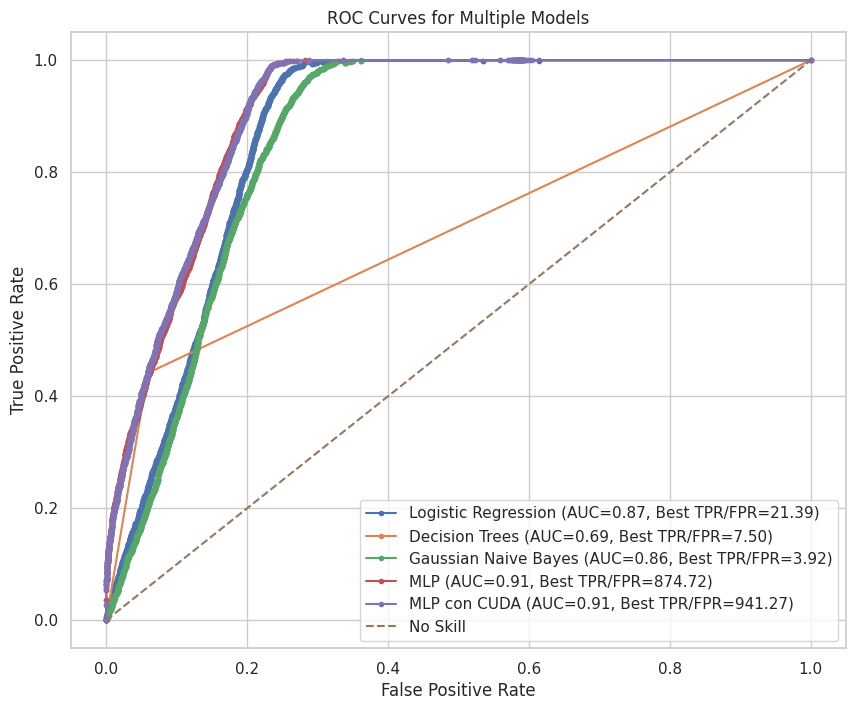

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch

def trazar_varias_curvas_titulos(models, testX, testy, model_names):
    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        if isinstance(model, torch.nn.Module):
            model.eval()
            device = next(model.parameters()).device  # Get the device of the model
            with torch.no_grad():
                if isinstance(testX, np.ndarray):
                    testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
                else:
                    testX_tensor = testX.to(device)
                model_probs = model(testX_tensor).softmax(dim=1)[:, 1].cpu().numpy()
        elif hasattr(model, "predict_proba"):
            model_probs = model.predict_proba(testX)[:, 1]
        elif hasattr(model, "decision_function"):
            model_probs = model.decision_function(testX)
        else:
            model_probs = model.predict(testX)

        # Calcular AUC
        model_auc = round(roc_auc_score(testy, model_probs), 2)

        # Calcular TPR y FPR
        model_fpr, model_tpr, model_thr = roc_curve(testy, model_probs)

        # Calcular TPR/FPR ratio, excluyendo puntos donde FPR es 0
        with np.errstate(divide='ignore', invalid='ignore'):
            tpr_fpr_ratio = np.where(model_fpr != 0, model_tpr / model_fpr, np.nan)

        # Encontrar el punto donde TPR/FPR es máximo (excluyendo infinito)
        best_idx = np.nanargmax(tpr_fpr_ratio)
        best_tpr = model_tpr[best_idx]
        best_fpr = model_fpr[best_idx]
        best_ratio = tpr_fpr_ratio[best_idx]
        best_threshold = model_thr[best_idx]

        model_title = '{} (AUC={}, Best TPR/FPR={:.2f})'.format(
            model_names[i], model_auc, best_ratio)
        plt.plot(model_fpr, model_tpr, marker='.', label=model_title)

        print(f"{model_names[i]}:")
        print(f"  AUC: {model_auc}")
        print(f"  Best TPR/FPR: {best_ratio:.2f}")
        print(f"  TPR at this point: {best_tpr:.4f}")
        print(f"  FPR at this point: {best_fpr:.4f}")
        print(f"  At threshold: {best_threshold:.4f}")
        print("")

    # Clasificador de referencia (No Skill)
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

# Create a list with the trained models
models = [logreg_model, dtc_model, nb_model, mlp_model, mlp_model_cuda]

# Create a list with the model names
model_names = ['Logistic Regression', 'Decision Trees', 'Gaussian Naive Bayes', "MLP", "MLP con CUDA"]

# Call the function to plot ROC curves and calculate metrics
trazar_varias_curvas_titulos(models, X_test, y_test, model_names)

Logistic Regression:
  AUC: 0.87
  Best TPR/FPR: 21.39
  TPR at this point: 0.0052
  FPR at this point: 0.0002
  At threshold: 0.9515

K-Nearest Neighbors (KNN):
  AUC: 0.85
  Best TPR/FPR: 6.50
  TPR at this point: 0.4130
  FPR at this point: 0.0635
  At threshold: 1.0000

Support Vector Machine (SVM):
  AUC: 0.89
  Best TPR/FPR: 190.16
  TPR at this point: 0.0116
  FPR at this point: 0.0001
  At threshold: 0.9737

Decision Trees:
  AUC: 0.69
  Best TPR/FPR: 7.50
  TPR at this point: 0.4413
  FPR at this point: 0.0588
  At threshold: 1.0000

Gaussian Naive Bayes:
  AUC: 0.86
  Best TPR/FPR: 3.92
  TPR at this point: 0.6761
  FPR at this point: 0.1723
  At threshold: 0.6013

Random Forest:
  AUC: 0.92
  Best TPR/FPR: 494.41
  TPR at this point: 0.0301
  FPR at this point: 0.0001
  At threshold: 0.9955

Voting Classifier:
  AUC: 0.86
  Best TPR/FPR: 4.60
  TPR at this point: 0.9184
  FPR at this point: 0.1995
  At threshold: 1.0000

Gradient Boosting:
  AUC: 0.93
  Best TPR/FPR: 865.21


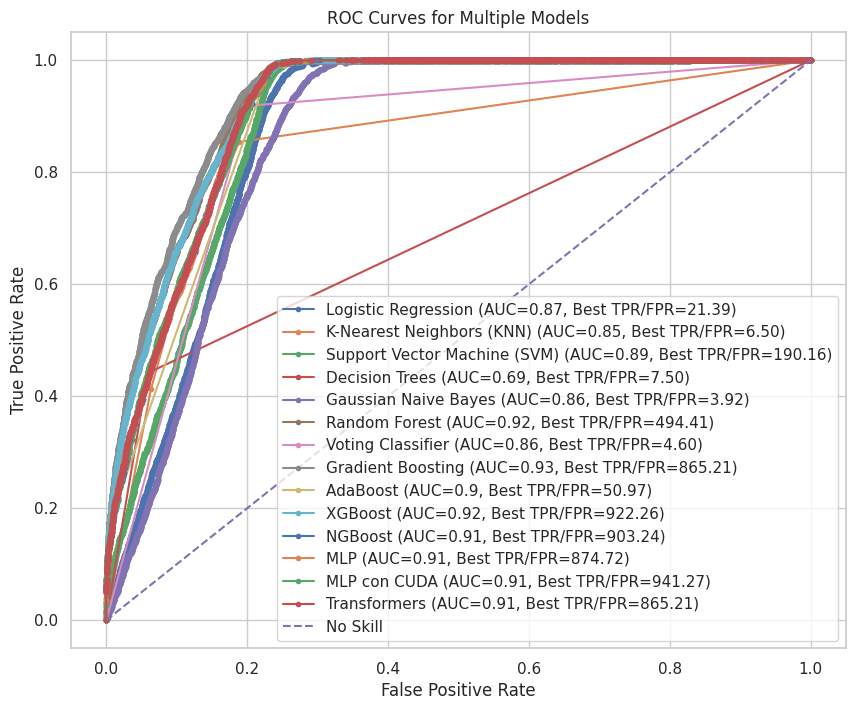

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch

def trazar_varias_curvas_titulos(models, testX, testy, model_names):
    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        if isinstance(model, torch.nn.Module):
            model.eval()
            device = next(model.parameters()).device  # Get the device of the model
            with torch.no_grad():
                if isinstance(testX, np.ndarray):
                    testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
                else:
                    testX_tensor = testX.to(device)
                model_probs = model(testX_tensor).softmax(dim=1)[:, 1].cpu().numpy()
        elif hasattr(model, "predict_proba"):
            model_probs = model.predict_proba(testX)[:, 1]
        elif hasattr(model, "decision_function"):
            model_probs = model.decision_function(testX)
        else:
            model_probs = model.predict(testX)

        # Calcular AUC
        model_auc = round(roc_auc_score(testy, model_probs), 2)

        # Calcular TPR y FPR
        model_fpr, model_tpr, model_thr = roc_curve(testy, model_probs)

        # Calcular TPR/FPR ratio, excluyendo puntos donde FPR es 0
        with np.errstate(divide='ignore', invalid='ignore'):
            tpr_fpr_ratio = np.where(model_fpr != 0, model_tpr / model_fpr, np.nan)

        # Encontrar el punto donde TPR/FPR es máximo (excluyendo infinito)
        best_idx = np.nanargmax(tpr_fpr_ratio)
        best_tpr = model_tpr[best_idx]
        best_fpr = model_fpr[best_idx]
        best_ratio = tpr_fpr_ratio[best_idx]
        best_threshold = model_thr[best_idx]

        model_title = '{} (AUC={}, Best TPR/FPR={:.2f})'.format(
            model_names[i], model_auc, best_ratio)
        plt.plot(model_fpr, model_tpr, marker='.', label=model_title)

        print(f"{model_names[i]}:")
        print(f"  AUC: {model_auc}")
        print(f"  Best TPR/FPR: {best_ratio:.2f}")
        print(f"  TPR at this point: {best_tpr:.4f}")
        print(f"  FPR at this point: {best_fpr:.4f}")
        print(f"  At threshold: {best_threshold:.4f}")
        print("")

    # Clasificador de referencia (No Skill)
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

# Create a list with the trained models
models = [logreg_model, knn_model, svm_model, dtc_model, nb_model, rf_model, voting_model, gb_model, ada_model, xgb_model, ngb_model, mlp_model, mlp_model_cuda, transformer_model]

# Create a list with the model names
model_names = ["Logistic Regression", "K-Nearest Neighbors (KNN)", "Support Vector Machine (SVM)",
"Decision Trees", "Gaussian Naive Bayes", "Random Forest",
"Voting Classifier", "Gradient Boosting", "AdaBoost", "XGBoost", "NGBoost",
"MLP", "MLP con CUDA", "Transformers"]

# Call the function to plot ROC curves and calculate metrics
trazar_varias_curvas_titulos(models, X_test, y_test, model_names)

**Los modelos con los AUC más altos son:**
*   Gradient Boosting: AUC = 0.93
*   Random Forest: AUC = 0.92
*   XGBoost: AUC = 0.92
*   NGBoost: AUC = 0.91
*   MLP: AUC = 0.91
*   MLP con CUDA: AUC = 0.91
*   Transformers: AUC = 0.91

Dentro de los modelos con AUC = 0.91, se escoge el MLP con CUDA, y se descarta el Random Forest.

**Comparación Final**
*   Gradient Boosting: AUC = 0.93, TPR/FPR = 865.21
*   XGBoost: AUC = 0.92, TPR/FPR = 922.26
*   MLP con CUDA: AUC = 0.91, TPR/FPR = 941.27

Gradient Boosting:
  AUC: 0.93
  Best TPR/FPR: 865.21
  TPR at this point: 0.0526
  FPR at this point: 0.0001
  At threshold: 0.9893

XGBoost:
  AUC: 0.92
  Best TPR/FPR: 922.26
  TPR at this point: 0.0561
  FPR at this point: 0.0001
  At threshold: 0.9977

MLP con CUDA:
  AUC: 0.91
  Best TPR/FPR: 941.27
  TPR at this point: 0.0573
  FPR at this point: 0.0001
  At threshold: 0.9863



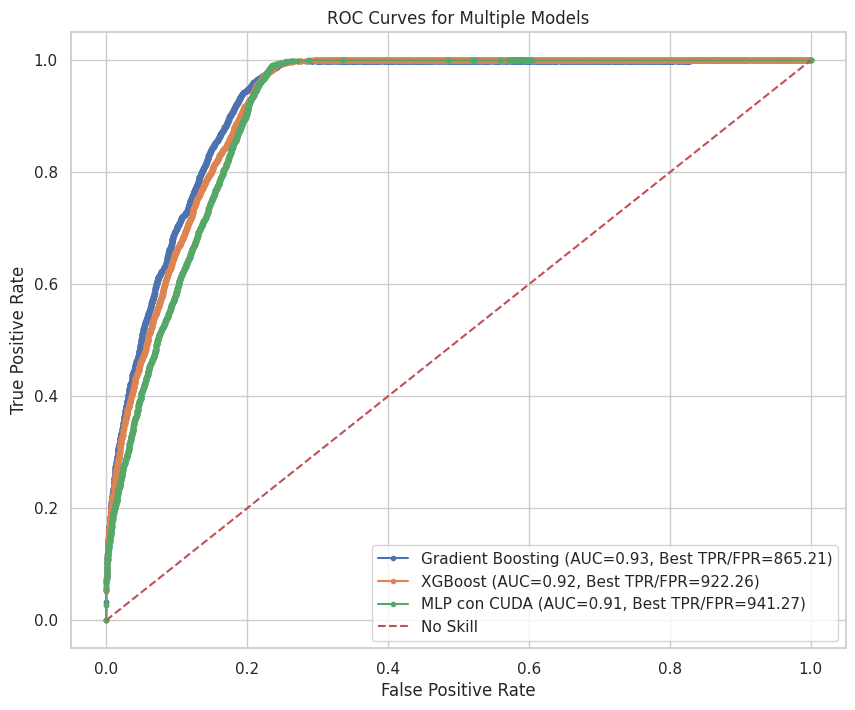

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch

def trazar_varias_curvas_titulos(models, testX, testy, model_names):
    plt.figure(figsize=(10, 8))

    for i, model in enumerate(models):
        if isinstance(model, torch.nn.Module):
            model.eval()
            device = next(model.parameters()).device  # Get the device of the model
            with torch.no_grad():
                if isinstance(testX, np.ndarray):
                    testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
                else:
                    testX_tensor = testX.to(device)
                model_probs = model(testX_tensor).softmax(dim=1)[:, 1].cpu().numpy()
        elif hasattr(model, "predict_proba"):
            model_probs = model.predict_proba(testX)[:, 1]
        elif hasattr(model, "decision_function"):
            model_probs = model.decision_function(testX)
        else:
            model_probs = model.predict(testX)

        # Calcular AUC
        model_auc = round(roc_auc_score(testy, model_probs), 2)

        # Calcular TPR y FPR
        model_fpr, model_tpr, model_thr = roc_curve(testy, model_probs)

        # Calcular TPR/FPR ratio, excluyendo puntos donde FPR es 0
        with np.errstate(divide='ignore', invalid='ignore'):
            tpr_fpr_ratio = np.where(model_fpr != 0, model_tpr / model_fpr, np.nan)

        # Encontrar el punto donde TPR/FPR es máximo (excluyendo infinito)
        best_idx = np.nanargmax(tpr_fpr_ratio)
        best_tpr = model_tpr[best_idx]
        best_fpr = model_fpr[best_idx]
        best_ratio = tpr_fpr_ratio[best_idx]
        best_threshold = model_thr[best_idx]

        model_title = '{} (AUC={}, Best TPR/FPR={:.2f})'.format(
            model_names[i], model_auc, best_ratio)
        plt.plot(model_fpr, model_tpr, marker='.', label=model_title)

        print(f"{model_names[i]}:")
        print(f"  AUC: {model_auc}")
        print(f"  Best TPR/FPR: {best_ratio:.2f}")
        print(f"  TPR at this point: {best_tpr:.4f}")
        print(f"  FPR at this point: {best_fpr:.4f}")
        print(f"  At threshold: {best_threshold:.4f}")
        print("")

    # Clasificador de referencia (No Skill)
    ns_probs = [0 for _ in range(len(testy))]
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend()
    plt.show()

# Create a list with the trained models
models = [gb_model, xgb_model, mlp_model_cuda]

# Create a list with the model names
model_names = ["Gradient Boosting", "XGBoost", "MLP con CUDA"]

# Call the function to plot ROC curves and calculate metrics
trazar_varias_curvas_titulos(models, X_test, y_test, model_names)

# Additional analysis on top performing models

## Gradient Boosting

La característica más importante es: miss_distance

Importancia de las características:
              feature  importance
4       miss_distance    0.494110
0    est_diameter_min    0.246050
1   relative_velocity    0.116475
2  absolute_magnitude    0.073444
3    est_diameter_max    0.069921


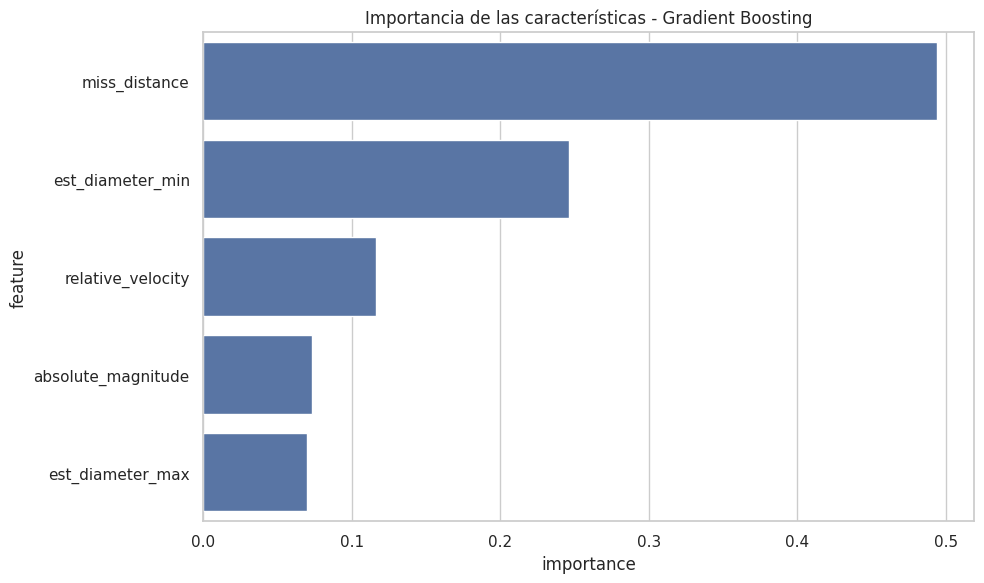

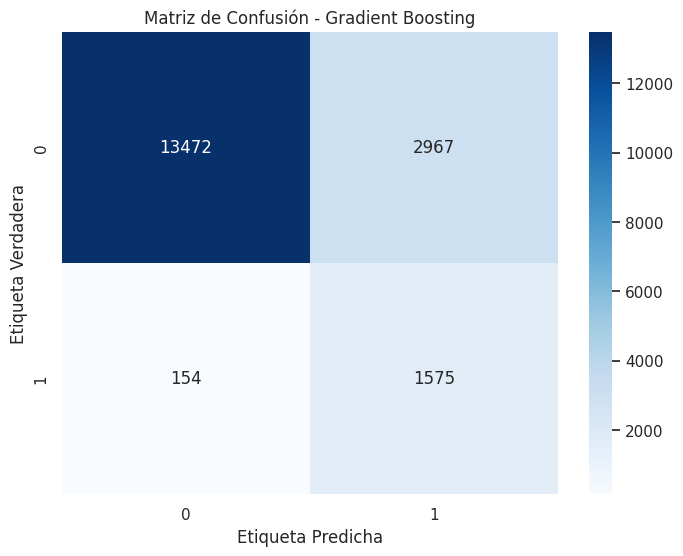


Número de falsos negativos: 154
Tasa de falsos negativos: 8.91%

Estadísticas de falsos negativos:
       est_diameter_min  relative_velocity  absolute_magnitude  \
count        330.000000         330.000000          330.000000   
mean          -0.409086          -0.409086           -0.353995   
std            0.472687           0.472687            0.933857   
min           -0.639239          -0.639239           -1.844572   
25%           -0.591667          -0.591667           -1.048983   
50%           -0.543359          -0.543359           -0.532864   
75%           -0.431070          -0.431070            0.112711   
max            2.913763           2.913763            3.860327   

       est_diameter_max  miss_distance  
count        330.000000     330.000000  
mean          -0.112937       0.836013  
std            1.044100       0.853449  
min           -1.748476      -1.838491  
25%           -1.046253       0.320360  
50%           -0.080930       0.890156  
75%            0.7

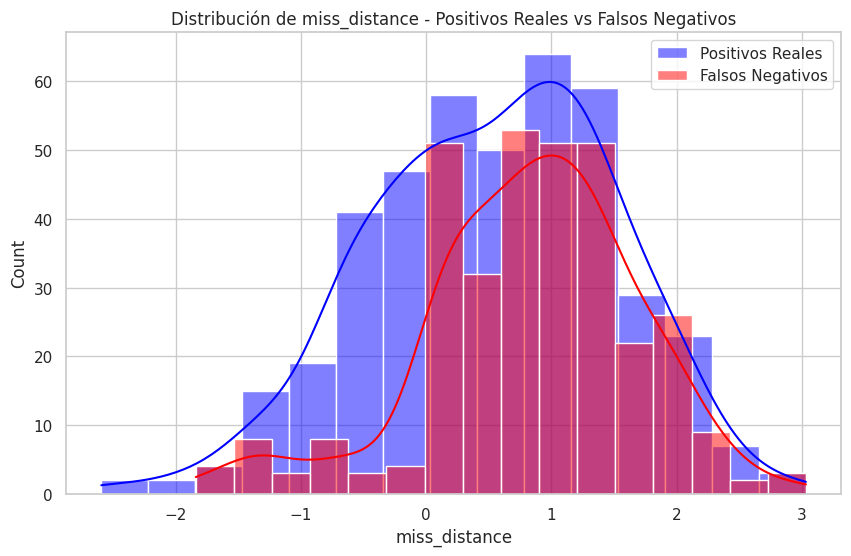

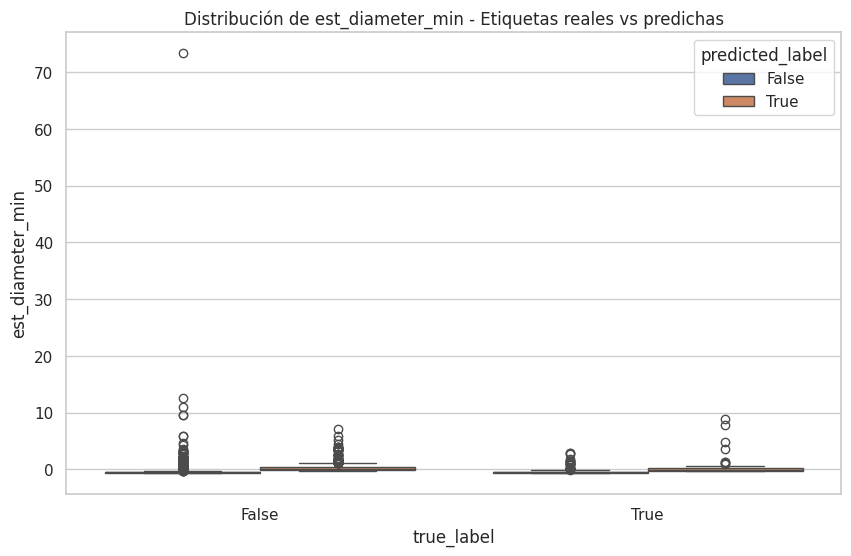

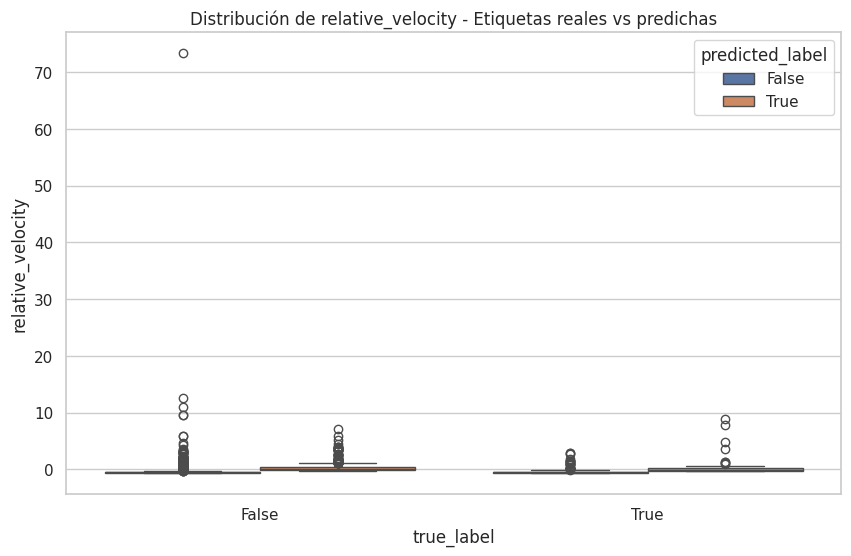

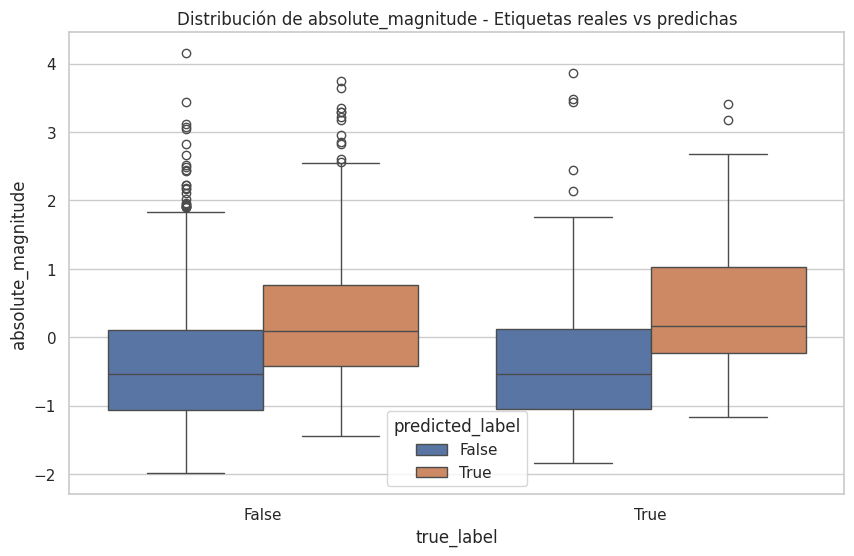

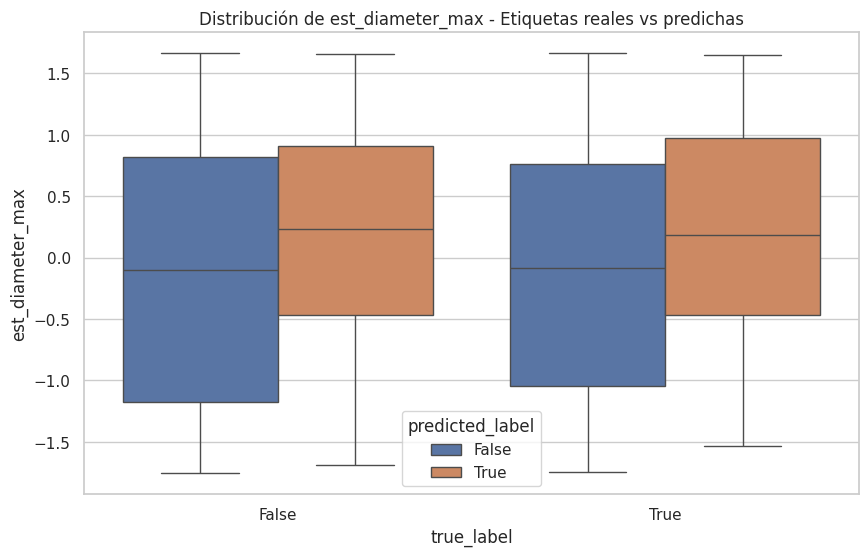

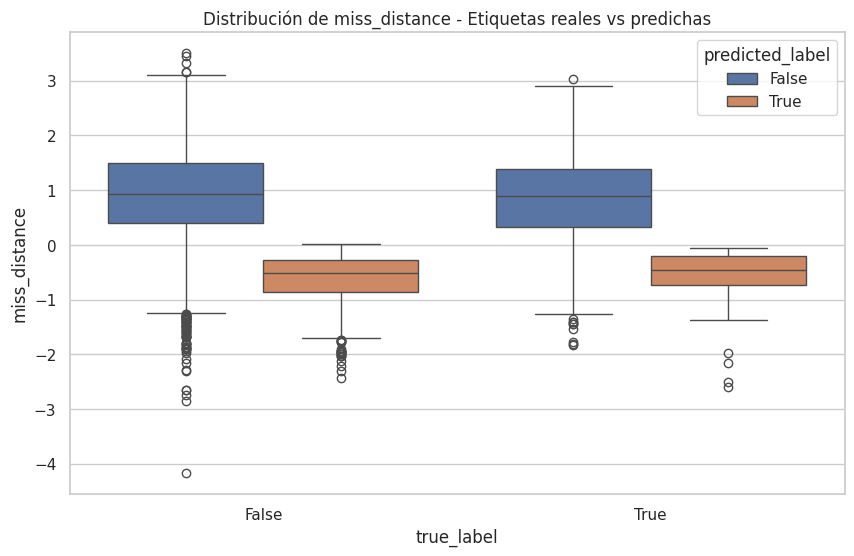


Comparación de estadísticas entre falsos negativos y positivos reales:

Característica: est_diameter_min
Falsos Negativos:
count    330.000000
mean      -0.409086
std        0.472687
min       -0.639239
25%       -0.591667
50%       -0.543359
75%       -0.431070
max        2.913763
Name: est_diameter_min, dtype: float64

Positivos Reales:
count    93.000000
mean      0.296525
std       1.386790
min      -0.296106
25%      -0.217617
50%      -0.052116
75%       0.208278
max       8.846617
Name: est_diameter_min, dtype: float64

Característica: relative_velocity
Falsos Negativos:
count    330.000000
mean      -0.409086
std        0.472687
min       -0.639239
25%       -0.591667
50%       -0.543359
75%       -0.431070
max        2.913763
Name: relative_velocity, dtype: float64

Positivos Reales:
count    93.000000
mean      0.296525
std       1.386790
min      -0.296106
25%      -0.217617
50%      -0.052116
75%       0.208278
max       8.846617
Name: relative_velocity, dtype: float64

Ca

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

# Obtener la importancia de las características
feature_importance = gb_model.feature_importances_
feature_columns = ['est_diameter_min', 'relative_velocity', 'absolute_magnitude', 'est_diameter_max', 'miss_distance']
feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Identificar la característica más importante
most_important_feature = feature_importance_df.iloc[0]['feature']
print(f"La característica más importante es: {most_important_feature}")

# Mostrar la importancia de todas las características
print("\nImportancia de las características:")
print(feature_importance_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las características - Gradient Boosting')
plt.tight_layout()
plt.show()

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_gb_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Calcular falsos negativos
fn = cm[1][0]
total_positivos = cm[1][0] + cm[1][1]
tasa_fn = fn / total_positivos if total_positivos > 0 else 0

print(f"\nNúmero de falsos negativos: {fn}")
print(f"Tasa de falsos negativos: {tasa_fn:.2%}")

# Analizar falsos negativos
X_test_df = pd.DataFrame(X_test, columns=feature_columns)
X_test_df['true_label'] = y_test
X_test_df['predicted_label'] = y_gb_pred

fn_samples = X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 0)]

print("\nEstadísticas de falsos negativos:")
print(fn_samples[feature_columns].describe())

# Visualizar la característica más importante
plt.figure(figsize=(10, 6))
sns.histplot(X_test_df[X_test_df['true_label'] == 1][most_important_feature],
             label='Positivos Reales', kde=True, color='blue', alpha=0.5)
sns.histplot(fn_samples[most_important_feature], label='Falsos Negativos',
             kde=True, color='red', alpha=0.5)
plt.title(f'Distribución de {most_important_feature} - Positivos Reales vs Falsos Negativos')
plt.legend()
plt.show()

# Comparar las distribuciones de las características para los falsos negativos y los positivos reales
for feature in feature_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y=feature, hue='predicted_label', data=X_test_df)
    plt.title(f'Distribución de {feature} - Etiquetas reales vs predichas')
    plt.show()

print("\nComparación de estadísticas entre falsos negativos y positivos reales:")
for feature in feature_columns:
    print(f"\nCaracterística: {feature}")
    print("Falsos Negativos:")
    print(fn_samples[feature].describe())
    print("\nPositivos Reales:")
    print(X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 1)][feature].describe())

## XGBoost

La característica más importante es: est_diameter_min

Importancia de las características:
              feature  importance
0    est_diameter_min    0.556351
4       miss_distance    0.342093
3    est_diameter_max    0.053359
2  absolute_magnitude    0.048197
1   relative_velocity    0.000000


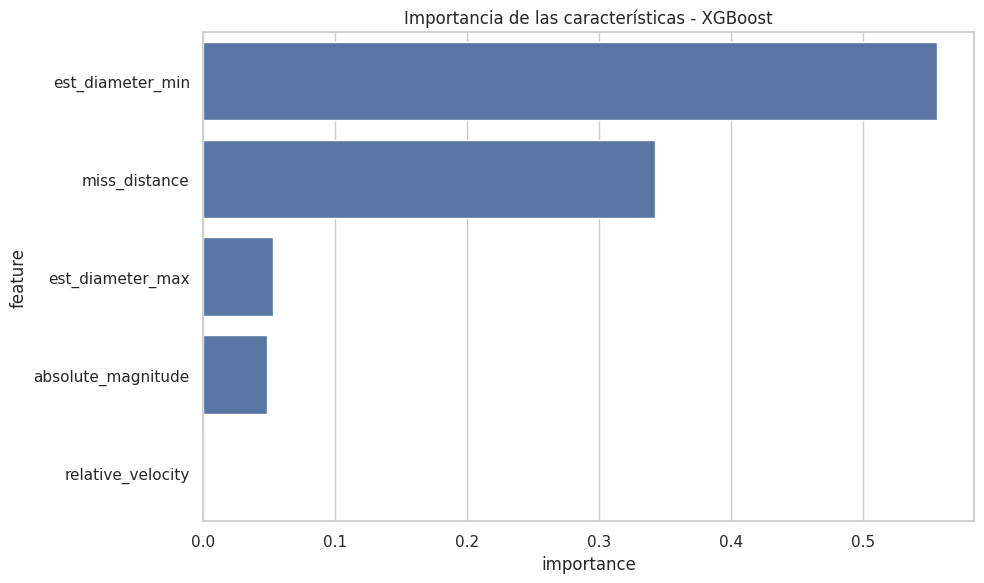

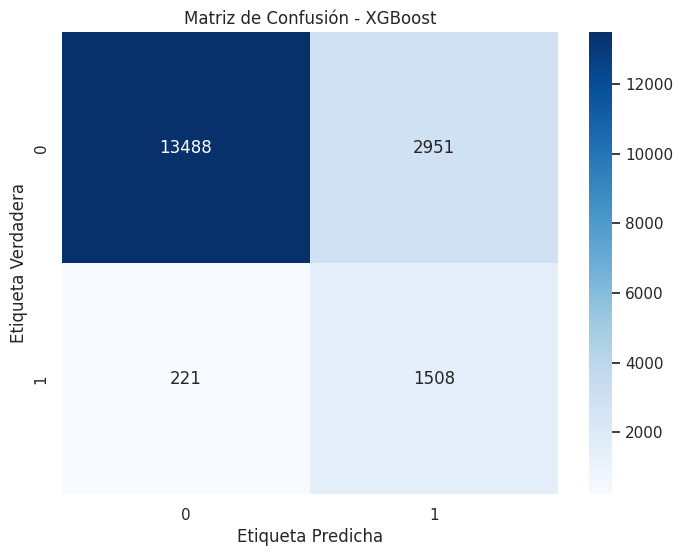


Número de falsos negativos: 221
Tasa de falsos negativos: 12.78%

Estadísticas de falsos negativos:
       est_diameter_min  relative_velocity  absolute_magnitude  \
count        329.000000         329.000000          329.000000   
mean          -0.413383          -0.413383           -0.365373   
std            0.602347           0.602347            0.914782   
min           -0.639239          -0.639239           -1.844572   
25%           -0.591667          -0.591667           -1.045020   
50%           -0.543829          -0.543829           -0.538000   
75%           -0.431070          -0.431070            0.111940   
max            7.814353           7.814353            3.860327   

       est_diameter_max  miss_distance  
count        329.000000     329.000000  
mean          -0.117381       0.852403  
std            1.045268       0.831284  
min           -1.748476      -2.503842  
25%           -1.046996       0.320360  
50%           -0.098261       0.893695  
75%            0.

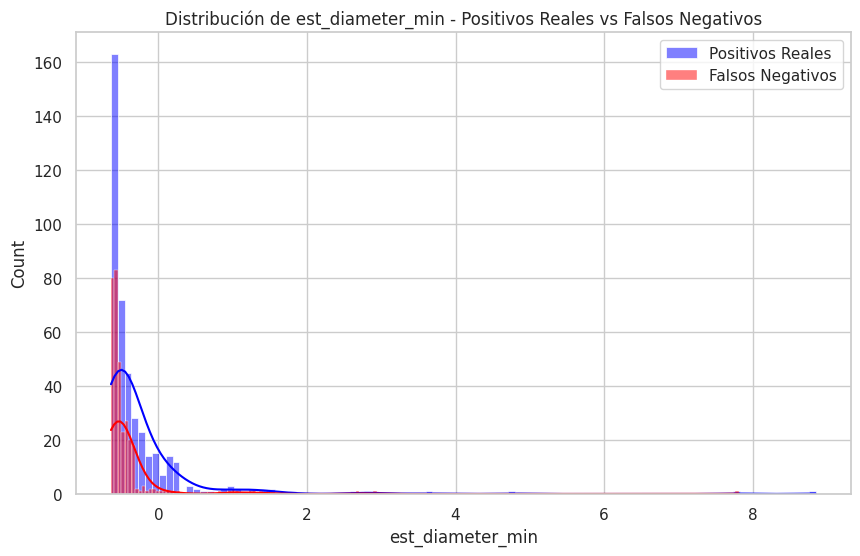

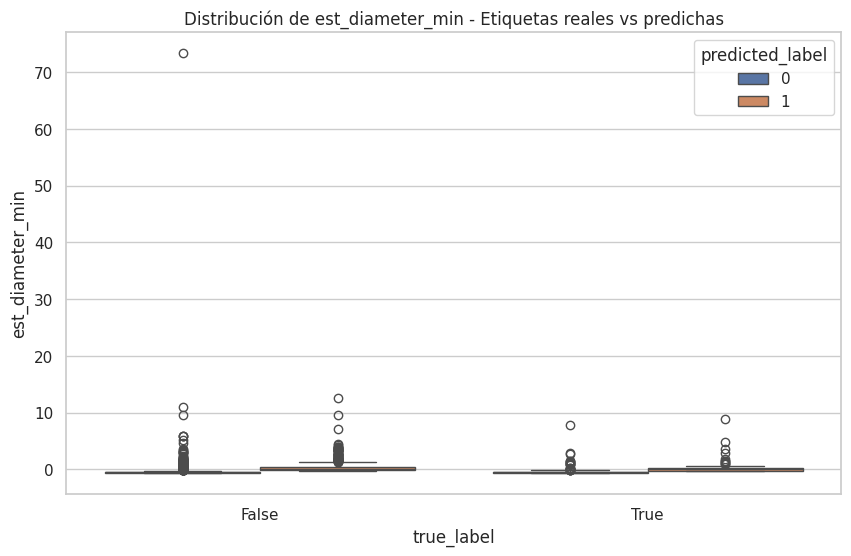

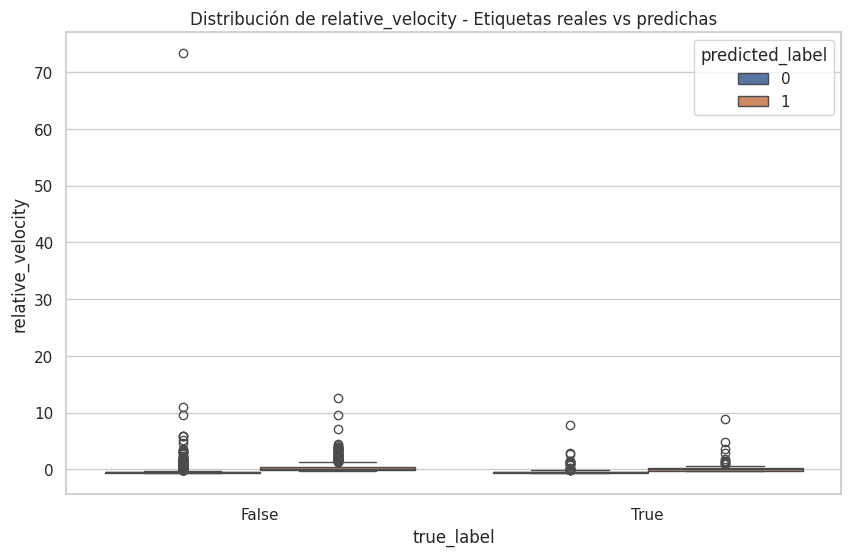

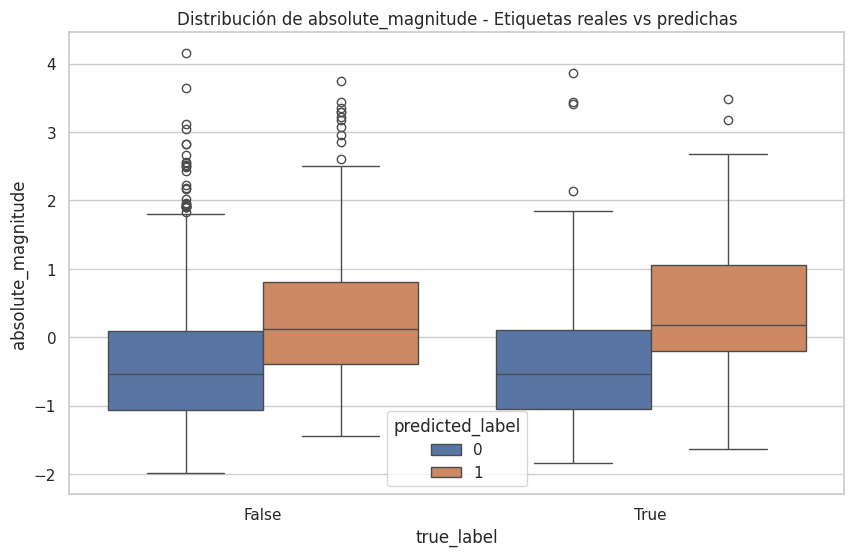

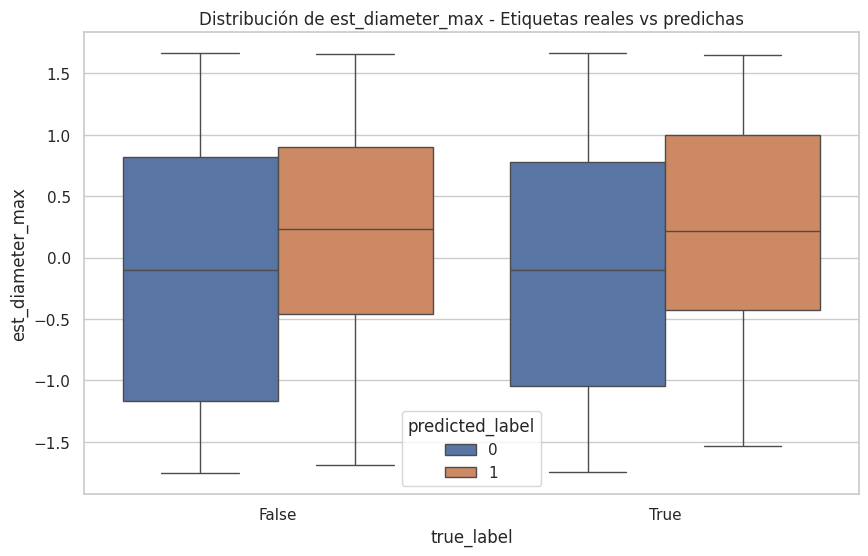

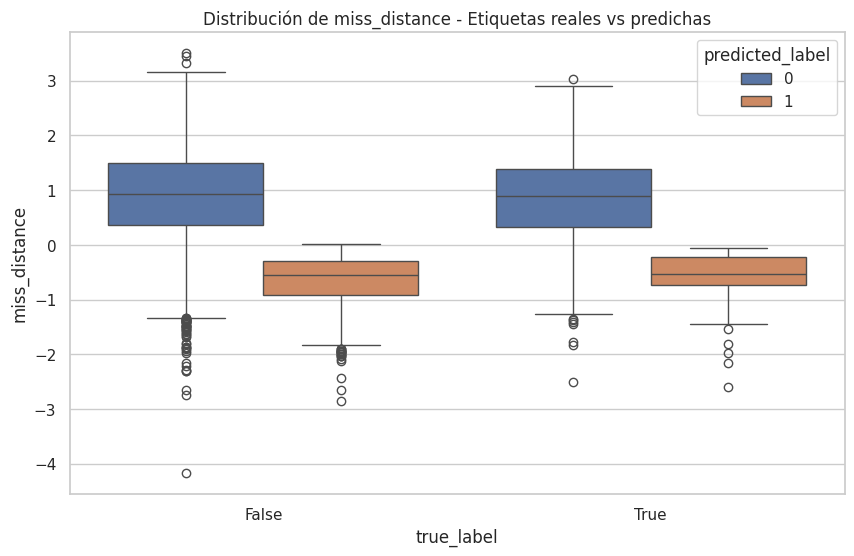


Comparación de estadísticas entre falsos negativos y positivos reales:

Característica: est_diameter_min
Falsos Negativos:
count    329.000000
mean      -0.413383
std        0.602347
min       -0.639239
25%       -0.591667
50%       -0.543829
75%       -0.431070
max        7.814353
Name: est_diameter_min, dtype: float64

Positivos Reales:
count    94.000000
mean      0.304055
std       1.181982
min      -0.296106
25%      -0.212575
50%       0.002147
75%       0.208278
max       8.846617
Name: est_diameter_min, dtype: float64

Característica: relative_velocity
Falsos Negativos:
count    329.000000
mean      -0.413383
std        0.602347
min       -0.639239
25%       -0.591667
50%       -0.543829
75%       -0.431070
max        7.814353
Name: relative_velocity, dtype: float64

Positivos Reales:
count    94.000000
mean      0.304055
std       1.181982
min      -0.296106
25%      -0.212575
50%       0.002147
75%       0.208278
max       8.846617
Name: relative_velocity, dtype: float64

Ca

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener la importancia de las características
feature_importance = xgb_model.feature_importances_
feature_columns = ['est_diameter_min', 'relative_velocity', 'absolute_magnitude', 'est_diameter_max', 'miss_distance']
feature_importance_df = pd.DataFrame({'feature': feature_columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Identificar la característica más importante
most_important_feature = feature_importance_df.iloc[0]['feature']
print(f"La característica más importante es: {most_important_feature}")

# Mostrar la importancia de todas las características
print("\nImportancia de las características:")
print(feature_importance_df)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las características - XGBoost')
plt.tight_layout()
plt.show()

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_xgboost)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Calcular falsos negativos
fn = cm[1][0]
total_positivos = cm[1][0] + cm[1][1]
tasa_fn = fn / total_positivos if total_positivos > 0 else 0

print(f"\nNúmero de falsos negativos: {fn}")
print(f"Tasa de falsos negativos: {tasa_fn:.2%}")

# Analizar falsos negativos
X_test_df = pd.DataFrame(X_test, columns=feature_columns)
X_test_df['true_label'] = y_test
X_test_df['predicted_label'] = y_pred_xgboost

fn_samples = X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 0)]

print("\nEstadísticas de falsos negativos:")
print(fn_samples[feature_columns].describe())

# Visualizar la característica más importante
plt.figure(figsize=(10, 6))
sns.histplot(X_test_df[X_test_df['true_label'] == 1][most_important_feature],
             label='Positivos Reales', kde=True, color='blue', alpha=0.5)
sns.histplot(fn_samples[most_important_feature], label='Falsos Negativos',
             kde=True, color='red', alpha=0.5)
plt.title(f'Distribución de {most_important_feature} - Positivos Reales vs Falsos Negativos')
plt.legend()
plt.show()

# Comparar las distribuciones de las características para los falsos negativos y los positivos reales
for feature in feature_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y=feature, hue='predicted_label', data=X_test_df)
    plt.title(f'Distribución de {feature} - Etiquetas reales vs predichas')
    plt.show()

print("\nComparación de estadísticas entre falsos negativos y positivos reales:")
for feature in feature_columns:
    print(f"\nCaracterística: {feature}")
    print("Falsos Negativos:")
    print(fn_samples[feature].describe())
    print("\nPositivos Reales:")
    print(X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 1)][feature].describe())

## MLP with CUDA

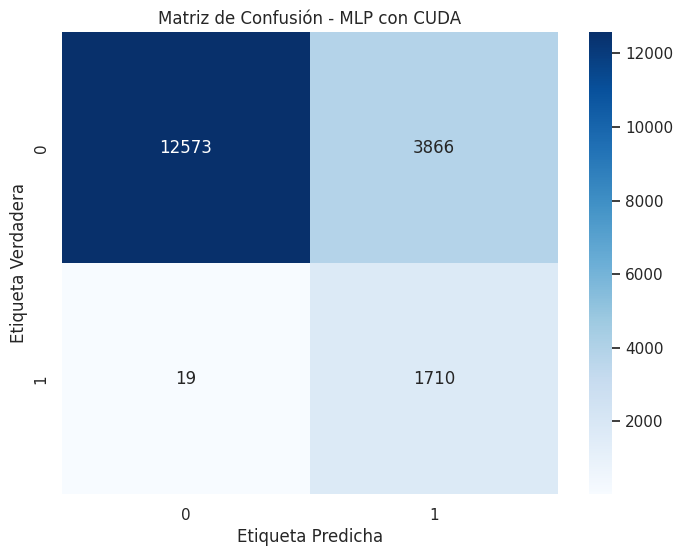


Número de falsos negativos: 19
Tasa de falsos negativos: 1.10%

Estadísticas de falsos negativos:
       est_diameter_min  relative_velocity  absolute_magnitude  \
count         19.000000          19.000000           19.000000   
mean           0.425926           0.425926           -0.163724   
std            2.970919           2.970919            0.987534   
min           -0.349490          -0.349490           -1.602983   
25%           -0.324622          -0.324622           -0.954279   
50%           -0.320927          -0.320927           -0.091368   
75%           -0.301488          -0.301488            0.513205   
max           12.639562          12.639562            2.248916   

       est_diameter_max  miss_distance  
count         19.000000      19.000000  
mean           0.267552      -0.211436  
std            1.207545       0.696825  
min           -1.491181      -2.850674  
25%           -1.016018      -0.042397  
50%            0.563751       0.001841  
75%            1.33

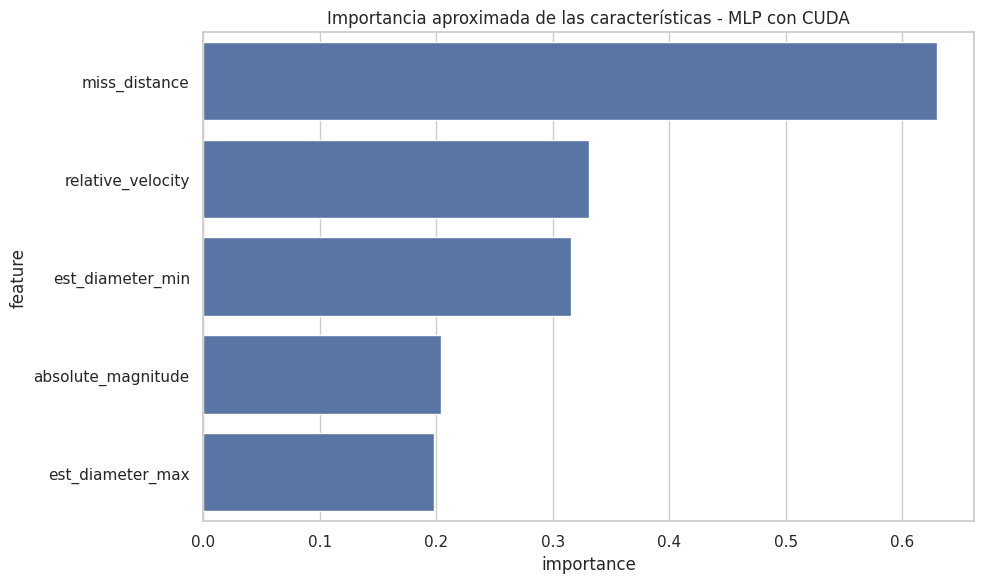

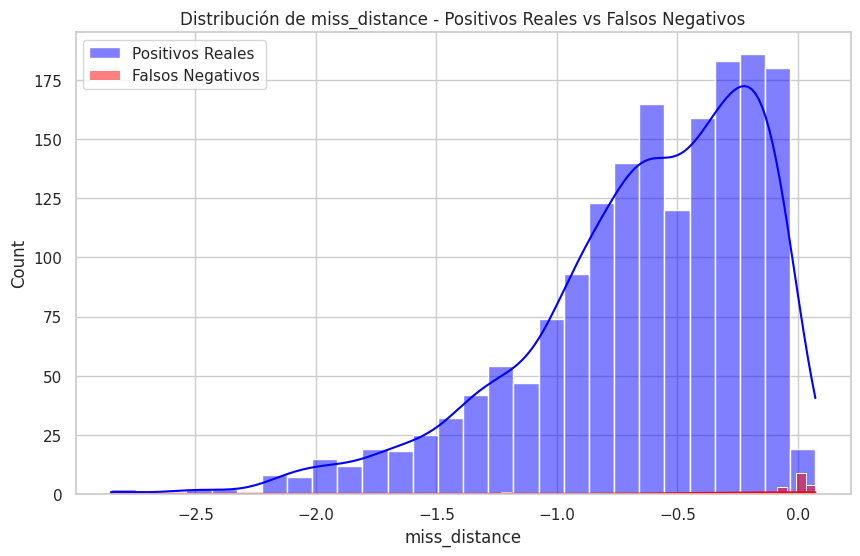

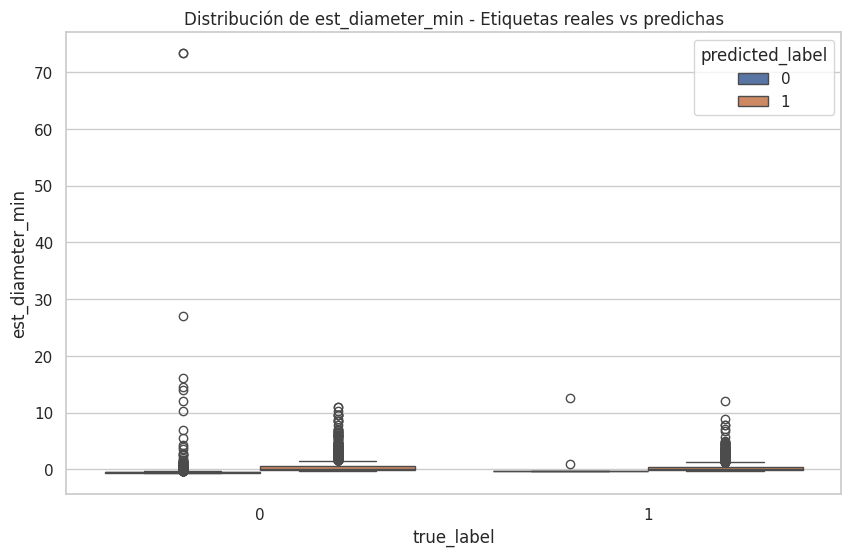

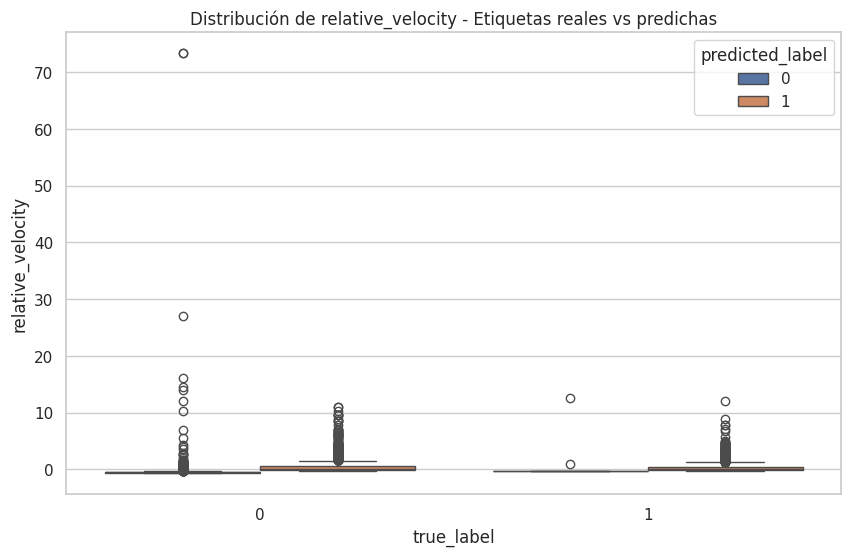

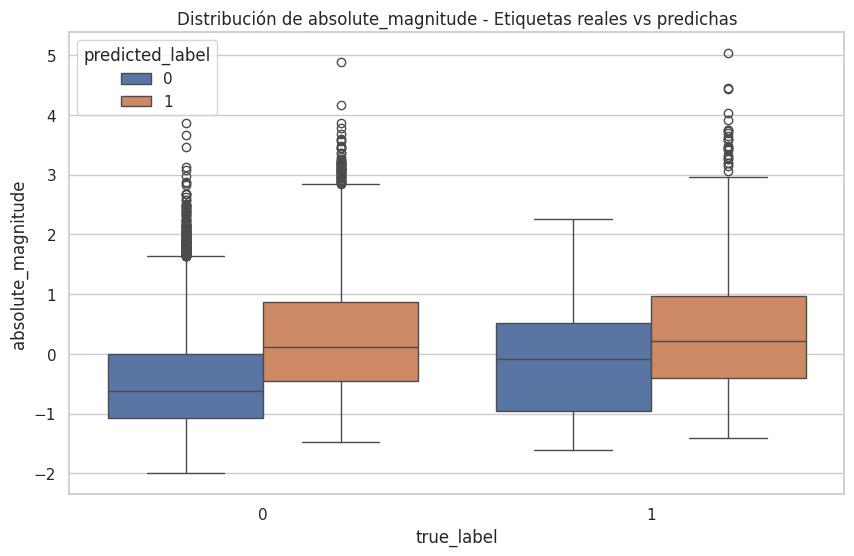

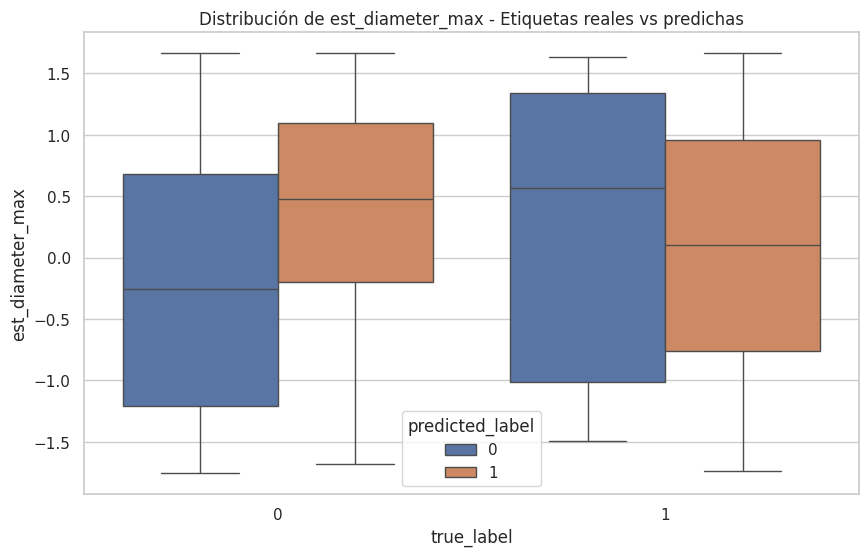

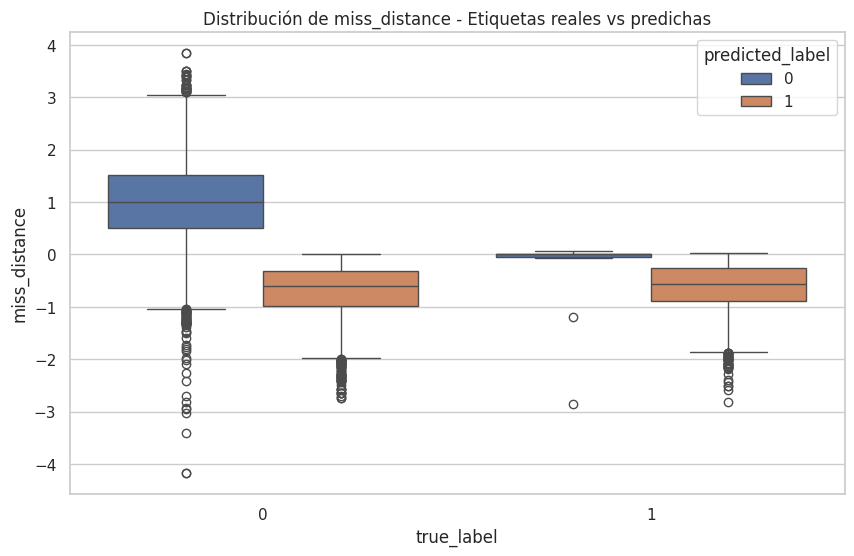


Comparación de estadísticas entre falsos negativos y positivos reales:

Característica: est_diameter_min
Falsos Negativos:
count    19.000000
mean      0.425926
std       2.970919
min      -0.349490
25%      -0.324622
50%      -0.320927
75%      -0.301488
max      12.639562
Name: est_diameter_min, dtype: float64

Positivos Reales:
count    1710.000000
mean        0.313986
std         0.936457
min        -0.328316
25%        -0.191216
50%         0.032672
75%         0.402544
max        12.100195
Name: est_diameter_min, dtype: float64

Característica: relative_velocity
Falsos Negativos:
count    19.000000
mean      0.425926
std       2.970919
min      -0.349490
25%      -0.324622
50%      -0.320927
75%      -0.301488
max      12.639562
Name: relative_velocity, dtype: float64

Positivos Reales:
count    1710.000000
mean        0.313986
std         0.936457
min        -0.328316
25%        -0.191216
50%         0.032672
75%         0.402544
max        12.100195
Name: relative_velocity, dt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix

# Convertir tensores a numpy para el análisis
X_test_np = X_test_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Crear la matriz de confusión
cm = confusion_matrix(y_test_np, preds_cuda)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - MLP con CUDA')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Calcular falsos negativos
fn = cm[1][0]
total_positivos = cm[1][0] + cm[1][1]
tasa_fn = fn / total_positivos if total_positivos > 0 else 0

print(f"\nNúmero de falsos negativos: {fn}")
print(f"Tasa de falsos negativos: {tasa_fn:.2%}")

# Analizar falsos negativos
feature_columns = ['est_diameter_min', 'relative_velocity', 'absolute_magnitude', 'est_diameter_max', 'miss_distance']
X_test_df = pd.DataFrame(X_test_np, columns=feature_columns)
X_test_df['true_label'] = y_test_np
X_test_df['predicted_label'] = preds_cuda

fn_samples = X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 0)]

print("\nEstadísticas de falsos negativos:")
print(fn_samples[feature_columns].describe())

# Analizar la importancia de las características
# Nota: MLP no tiene un atributo directo de importancia de características como los modelos basados en árboles
# Podemos usar los pesos de la primera capa como una aproximación

weights = mlp_model_cuda.fc1.weight.data.abs().mean(dim=0).cpu().numpy()
feature_importance = pd.DataFrame({'feature': feature_columns, 'importance': weights})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nImportancia aproximada de las características (basada en los pesos de la primera capa):")
print(feature_importance)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importancia aproximada de las características - MLP con CUDA')
plt.tight_layout()
plt.show()

# Identificar la característica más importante
most_important_feature = feature_importance.iloc[0]['feature']

# Visualizar la característica más importante
plt.figure(figsize=(10, 6))
sns.histplot(X_test_df[X_test_df['true_label'] == 1][most_important_feature],
             label='Positivos Reales', kde=True, color='blue', alpha=0.5)
sns.histplot(fn_samples[most_important_feature], label='Falsos Negativos',
             kde=True, color='red', alpha=0.5)
plt.title(f'Distribución de {most_important_feature} - Positivos Reales vs Falsos Negativos')
plt.legend()
plt.show()

# Comparar las distribuciones de las características para los falsos negativos y los positivos reales
for feature in feature_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y=feature, hue='predicted_label', data=X_test_df)
    plt.title(f'Distribución de {feature} - Etiquetas reales vs predichas')
    plt.show()

print("\nComparación de estadísticas entre falsos negativos y positivos reales:")
for feature in feature_columns:
    print(f"\nCaracterística: {feature}")
    print("Falsos Negativos:")
    print(fn_samples[feature].describe())
    print("\nPositivos Reales:")
    print(X_test_df[(X_test_df['true_label'] == 1) & (X_test_df['predicted_label'] == 1)][feature].describe())